In [1]:
# Module Import
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
import json
from IPython.display import display
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization,
    GRU, LSTM, Bidirectional,
    Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    LayerNormalization, MultiHeadAttention, Add
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tcn import TCN

In [2]:
# 데이터 전처리
data = pd.read_csv("../frontend/public/sensor.csv")

all_zero_cols = data.columns[(data == 0).all()].tolist()
all_nan_cols = data.columns[data.isna().all()].tolist()
threshold = 1.2
low_std_cols = data.std(numeric_only=True).loc[lambda x: x < threshold].index.tolist()
useless_columns = list(set(all_zero_cols + all_nan_cols + low_std_cols))
data = data.drop(columns=useless_columns)

status_map = {'NORMAL': 0, 'RECOVERING': 1, 'BROKEN': 2}
data['machine_status_encoded'] = data['machine_status'].map(status_map)

data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)
data = data.interpolate(method='time')

sensor_cols = [col for col in data.columns if col.startswith('sensor')]
scaler = StandardScaler()
data[sensor_cols] = scaler.fit_transform(data[sensor_cols])

data = data.drop(columns=['machine_status'])
data = data.sort_index()
data.columns

C:\Users\LEETJ\AppData\Local\Temp\ipykernel_13324\1390813879.py:16: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='time')


Index(['Unnamed: 0', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_19', 'sensor_20', 'sensor_21',
       'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26',
       'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31',
       'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36',
       'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41',
       'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46',
       'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50', 'sensor_51',
       'machine_status_encoded'],
      dtype='object')

In [3]:
# 데이터 분할 학습(60%), 테스트(40%)
total_rows = len(data)
split_idx = int(total_rows * 0.6)
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

print(total_rows)
print(len(train_data))
print(len(test_data))

220320
132192
88128


In [4]:
# 트렌드 예측 window 생성
def create_sensor_trend_windows(data, sensor_cols, window_size=60, step=1):
    sensor_data = data[sensor_cols].to_numpy(dtype=np.float32)
    num_windows = (len(sensor_data) - window_size) // step

    X = np.empty((num_windows, window_size, len(sensor_cols)), dtype=np.float32)
    y = np.empty((num_windows, len(sensor_cols)), dtype=np.float32)

    for i in range(num_windows):
        idx = i * step
        X[i] = sensor_data[idx:idx + window_size]
        y[i] = sensor_data[idx + window_size]
    return X, y

X_train, y_train = create_sensor_trend_windows(train_data, sensor_cols)
X_test, y_test = create_sensor_trend_windows(test_data, sensor_cols)

In [5]:
# 데이터 축소 (10% 샘플링)
subset_size = int(len(X_train) * 0.1)
X_train_small = X_train[:subset_size]
y_train_small = y_train[:subset_size]

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

def evaluate_model(name, y_true, y_pred):
    mse_list = [mean_squared_error(y_true[:, i], y_pred[:, i]) for i in range(len(sensor_cols))]
    return pd.DataFrame({'Sensor': sensor_cols, f'{name}_MSE': mse_list})

print(len(X_train_small))
print(len(y_train_small))

13213
13213


In [6]:
# 10% 데이터로 약식 평가
# GRU
gru_model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(len(sensor_cols))
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=5, batch_size=64, verbose=0)
gru_y_pred = gru_model.predict(X_test)
df_gru = evaluate_model('GRU', y_test, gru_y_pred)

# LSTM
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(len(sensor_cols))
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=5, batch_size=64, verbose=0)
lstm_y_pred = lstm_model.predict(X_test)
df_lstm = evaluate_model('LSTM', y_test, lstm_y_pred)

# BiLSTM
bilstm_model = Sequential([
    Bidirectional(LSTM(64), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(len(sensor_cols))
])
bilstm_model.compile(optimizer='adam', loss='mse')
bilstm_model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=5, batch_size=64, verbose=0)
bilstm_y_pred = bilstm_model.predict(X_test)
df_bilstm = evaluate_model('BiLSTM', y_test, bilstm_y_pred)

# TCN
tcn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    TCN(nb_filters=32, kernel_size=3, dilations=[1, 2, 4], dropout_rate=0.1),
    Dense(len(sensor_cols))
])
tcn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
tcn_model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=5, batch_size=64, verbose=0, callbacks=[early_stop])
tcn_y_pred = tcn_model.predict(X_test)
df_tcn = evaluate_model('TCN', y_test, tcn_y_pred)

# 1D-CNN
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    GlobalAveragePooling1D(),
    Dense(len(sensor_cols))
])
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=5, batch_size=64, verbose=0)
cnn_y_pred = cnn_model.predict(X_test)
df_cnn = evaluate_model('1D_CNN', y_test, cnn_y_pred)

# Transformer
def transformer_block(inputs, num_heads=2, ff_dim=64, dropout=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    ff_output = Dense(ff_dim, activation='relu')(out1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ff_output)

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = transformer_block(input_layer)
x = GlobalAveragePooling1D()(x)
output_layer = Dense(len(sensor_cols))(x)

transformer_model = Model(inputs=input_layer, outputs=output_layer)
transformer_model.compile(optimizer='adam', loss='mse')
transformer_model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=5, batch_size=64, verbose=0)
transformer_y_pred = transformer_model.predict(X_test)
df_trans = evaluate_model('Transformer', y_test, transformer_y_pred)

c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2753/2753 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2753/2753 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2753/2753 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step

2753/2753 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2753/2753 ━━━━━━━━━━━━━━━━━━━━ 2s 593us/step
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [7]:
# 약식 평가 MSE 결과
model_dfs = [df_gru, df_lstm, df_bilstm, df_tcn, df_cnn, df_trans]
model_names = ['GRU', 'LSTM', 'BiLSTM', 'TCN', '1D_CNN', 'Transformer']

df_all = pd.DataFrame()
for df, name in zip(model_dfs, model_names):
    df_temp = df.copy()
    df_temp.columns = ['Sensor', 'MSE']
    df_temp['Model'] = name
    df_all = pd.concat([df_all, df_temp], axis=0)

print("모델별 센서 예측 MSE")
display(df_all.pivot(index='Sensor', columns='Model', values='MSE'))

# 모델별 평균 성능 출력
print("모델별 평균 MSE 요약")
avg_mse_summary = df_all.groupby('Model')['MSE'].mean().sort_values()
display(avg_mse_summary.round(5).to_frame(name='Average_MSE'))


모델별 센서 예측 MSE


Model        1D_CNN    BiLSTM       GRU      LSTM       TCN  Transformer
Sensor                                                                  
sensor_01  0.228206  0.817459  0.210927  0.847865  1.981077     0.603596
sensor_02  0.301572  1.385545  0.961501  1.080177  0.878190     1.264256
sensor_03  0.136358  0.549783  0.224219  0.704300  0.534290     0.361233
sensor_04  0.267671  0.811648  0.796283  0.829698  1.110712     0.640791
sensor_05  0.574692  0.533634  0.275190  0.460283  0.829895     0.894570
sensor_06  0.533288  1.084434  0.797955  0.996367  1.286356     0.932039
sensor_07  1.585788  1.212254  1.080027  1.077524  1.456941     0.899868
sensor_08  0.966402  1.013355  1.120405  1.247322  1.468589     1.040393
sensor_09  0.865700  1.033302  0.841706  0.971954  1.157124     1.357657
sensor_10  0.751462  0.561905  0.340257  0.584789  0.419726     0.702910
sensor_11  0.886767  0.838337  0.431642  0.637100  0.898208     0.585450
sensor_12  0.227521  0.601255  0.239896  0.498008  0.713342     0.884548
sensor_13  0.789343  0.196242  0.066965  0.262114  1.305086     1.972332
sensor_14  0.106884  0.073977  0.152777  0.153387  0.089221     0.208899
sensor_16  0.347577  0.080363  0.195370  0.184488  0.105816     0.100299
sensor_17  0.054918  0.072848  0.045227  0.111782  0.058927     0.169544
sensor_19  0.246151  0.064340  0.136449  0.101609  0.047344     0.431453
sensor_20  0.146271  0.232890  0.120832  0.094304  0.109342     0.117262
sensor_21  0.125350  0.066337  0.119007  0.159131  0.069697     0.121159
sensor_22  0.164767  0.362774  0.127096  0.204197  0.240938     0.176104
sensor_23  0.313028  0.360790  0.312599  0.562033  0.287099     0.211394
sensor_24  0.155049  0.251319  0.223944  0.186015  0.092367     0.166579
sensor_25  0.067684  0.147711  0.053074  0.099805  0.128479     0.282992
sensor_26  0.206014  0.529199  0.375642  0.316210  0.301496     0.323597
sensor_27  0.684263  0.516015  0.390810  0.365458  1.133553     0.780247
sensor_28  0.390991  0.124469  0.086076  0.143062  0.542909     0.296108
sensor_29  0.396397  0.396715  0.506023  0.483080  1.511003     1.183123
sensor_30  0.220655  0.207738  0.409236  0.224909  0.268632     0.365117
sensor_31  0.113735  0.186832  0.119829  0.098645  0.305974     0.189903
sensor_32  0.578103  0.471169  0.453196  0.281462  0.594856     0.324964
sensor_33  0.247962  0.102480  0.050463  0.130490  0.171542     0.492689
sensor_34  1.154456  0.816350  0.707757  1.272856  2.826927     1.518775
sensor_35  1.860168  0.848327  0.511942  1.013706  2.322475     2.465243
sensor_36  1.024923  0.071816  0.207533  0.343007  2.424746     0.600269
sensor_37  1.635535  0.947390  0.519513  0.825420  4.307281     2.509360
sensor_38  0.641858  0.545026  0.335310  0.535302  0.692091     0.915332
sensor_39  0.643342  0.606668  0.308493  0.467403  0.615211     0.677392
sensor_40  1.176012  0.253124  0.297504  0.358191  1.092656     2.471765
sensor_41  0.546301  0.480553  0.449002  0.462434  0.489846     0.554365
sensor_42  0.332655  0.371793  0.225572  0.281375  0.298586     0.431483
sensor_43  0.806844  0.470581  0.266619  0.332029  0.447181     3.684283
sensor_44  1.422947  0.948210  0.742304  0.683887  1.208369     1.527380
sensor_45  1.797365  0.329599  0.274512  0.333418  2.077090     6.482366
sensor_46  1.973748  0.523156  0.793630  0.389911  0.801170     9.436611
sensor_47  1.531711  0.795116  0.360098  0.737057  1.577108     1.362630
sensor_48  0.929948  0.271154  0.091586  0.327937  0.580864     0.542690
sensor_49  0.700374  0.453429  0.223426  0.676174  0.759344     1.839229
sensor_50  2.259005  2.346783  1.880883  2.248328  3.562297     2.443626
sensor_51  0.215328  0.294842  0.194179  0.249446  0.255603     0.291187

모델별 평균 MSE 요약


Average_MSE
Model                   
GRU              0.40111
LSTM             0.52317
BiLSTM           0.53594
1D_CNN           0.68027
TCN              0.94771
Transformer      1.18031

In [8]:
# 주요 모델 전체 데이터로 학습 (GRU, BiLSTM, LSTM)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# GRU
gru_trend_model = Sequential([
    GRU(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(len(sensor_cols))
])
gru_trend_model.compile(
    optimizer='adam',
    loss='mse'
)
gru_trend_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=[early_stop],
    verbose=0
)

# BiLSTM
bilstm_trend_model = Sequential([
    Bidirectional(LSTM(128), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(len(sensor_cols))
])
bilstm_trend_model.compile(
    optimizer='adam',
    loss='mse'
)
bilstm_trend_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=[early_stop],
    verbose=0
)

# LSTM
lstm_trend_model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(len(sensor_cols))
])
lstm_trend_model.compile(
    optimizer='adam',
    loss='mse'
)
lstm_trend_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=[early_stop],
    verbose=0
)

c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# GRU, BiLSTM, LSTM 학습 평가
models_info = {
    "GRU": gru_trend_model,
    "LSTM": lstm_trend_model,
    "BiLSTM": bilstm_trend_model
}

all_metrics = {}

for model_name, model in models_info.items():
    X_init = train_data[sensor_cols].values[-60:].reshape(1, 60, len(sensor_cols))
    first_y_pred = model.predict(X_init, verbose=0)
    y_pred_rest = model.predict(X_test, verbose=0)
    y_pred_full = np.vstack([first_y_pred, y_pred_rest])

    metrics = []
    for i, sensor in enumerate(sensor_cols):
        pred = y_pred_full[:, i]
        actual = y_test[:, i]

        mse = mean_squared_error(actual, pred[1:])
        mae = mean_absolute_error(actual, pred[1:])
        r2 = r2_score(actual, pred[1:])

        metrics.append({
            "Sensor": sensor,
            "MSE": round(mse, 5),
            "MAE": round(mae, 5),
            "R2": round(r2, 5)
        })

    df = pd.DataFrame(metrics)
    df["Model"] = model_name
    all_metrics[model_name] = df

combined_df = pd.concat(all_metrics.values(), ignore_index=True)

print("센서별 모델 성능 (MSE/MAE/R²)")
display(combined_df.pivot(index='Sensor', columns='Model', values='MSE').round(5))
display(combined_df.pivot(index='Sensor', columns='Model', values='MAE').round(5))
display(combined_df.pivot(index='Sensor', columns='Model', values='R2').round(5))

print("모델별 평균 성능 요약")
avg_summary_df = combined_df.groupby("Model")[["MSE", "MAE", "R2"]].mean().round(5)
display(avg_summary_df)


센서별 모델 성능 (MSE/MAE/R²)


Model       BiLSTM      GRU     LSTM
Sensor                              
sensor_01  0.37301  0.02775  0.17602
sensor_02  0.43014  0.01587  0.07899
sensor_03  0.10427  0.01840  0.14535
sensor_04  0.11174  0.02285  0.02689
sensor_05  0.59068  0.03856  0.09019
sensor_06  0.06434  0.02588  0.04599
sensor_07  0.13043  0.02939  0.02523
sensor_08  0.33182  0.02312  0.02645
sensor_09  0.07269  0.01550  0.02485
sensor_10  0.30954  0.03386  0.06652
sensor_11  0.13208  0.03319  0.13019
sensor_12  0.17450  0.01934  0.08851
sensor_13  0.26237  0.04282  0.25795
sensor_14  0.11711  0.00888  0.00938
sensor_16  0.20063  0.01104  0.04339
sensor_17  0.09054  0.01193  0.01419
sensor_19  0.10974  0.00623  0.00650
sensor_20  0.06111  0.00855  0.00785
sensor_21  0.08242  0.00725  0.01670
sensor_22  0.03155  0.00934  0.02090
sensor_23  0.54755  0.00780  0.05095
sensor_24  0.05343  0.01779  0.01243
sensor_25  0.09257  0.01008  0.02491
sensor_26  0.11336  0.01213  0.03689
sensor_27  0.33103  0.07363  0.34021
sensor_28  0.10053  0.01196  0.11107
sensor_29  0.13994  0.02109  0.12474
sensor_30  0.07030  0.01848  0.08597
sensor_31  0.07008  0.06606  0.12267
sensor_32  0.27719  0.01401  0.10729
sensor_33  0.29120  0.01273  0.02719
sensor_34  0.31053  0.03454  0.12515
sensor_35  0.15680  0.05626  0.13042
sensor_36  0.45382  0.02045  0.05035
sensor_37  0.35914  0.09244  0.49289
sensor_38  0.67010  0.08607  0.08052
sensor_39  1.08723  0.05871  0.07901
sensor_40  1.15994  0.20904  0.12143
sensor_41  1.89254  0.10306  0.08145
sensor_42  1.10622  0.06326  0.06056
sensor_43  2.80296  0.15980  0.05772
sensor_44  1.12754  0.32934  0.47216
sensor_45  0.42076  0.18459  0.13286
sensor_46  0.23831  0.18451  0.11116
sensor_47  0.64409  0.11910  0.18010
sensor_48  0.15977  0.12879  0.09822
sensor_49  0.27038  0.15214  0.17014
sensor_50  0.99300  0.01792  0.57046
sensor_51  0.33692  0.01857  0.09331

Model       BiLSTM      GRU     LSTM
Sensor                              
sensor_01  0.48335  0.09779  0.33397
sensor_02  0.57966  0.07439  0.21677
sensor_03  0.24543  0.09951  0.31908
sensor_04  0.25453  0.11654  0.10299
sensor_05  0.66076  0.15606  0.23300
sensor_06  0.18654  0.11757  0.17138
sensor_07  0.28593  0.13904  0.10415
sensor_08  0.48168  0.10359  0.10168
sensor_09  0.19445  0.06091  0.09230
sensor_10  0.47569  0.14215  0.20277
sensor_11  0.28636  0.14418  0.31497
sensor_12  0.32941  0.09997  0.24346
sensor_13  0.39770  0.15181  0.41944
sensor_14  0.27584  0.06437  0.06513
sensor_16  0.34800  0.08207  0.18688
sensor_17  0.23776  0.08417  0.08676
sensor_19  0.25726  0.04714  0.05345
sensor_20  0.19108  0.07229  0.05962
sensor_21  0.23677  0.06900  0.10495
sensor_22  0.12843  0.06581  0.10852
sensor_23  0.67380  0.06022  0.21129
sensor_24  0.17563  0.10869  0.06921
sensor_25  0.25370  0.07524  0.12942
sensor_26  0.28396  0.09099  0.15746
sensor_27  0.32774  0.17690  0.31875
sensor_28  0.22436  0.07359  0.23009
sensor_29  0.30920  0.10646  0.32388
sensor_30  0.20088  0.10161  0.24124
sensor_31  0.20124  0.20003  0.28052
sensor_32  0.41945  0.08330  0.26885
sensor_33  0.46713  0.08069  0.11835
sensor_34  0.45040  0.14127  0.29010
sensor_35  0.30358  0.18780  0.28857
sensor_36  0.59372  0.11368  0.18555
sensor_37  0.49543  0.23024  0.59899
sensor_38  0.64677  0.19824  0.18746
sensor_39  0.90414  0.14807  0.22861
sensor_40  0.89652  0.32491  0.24940
sensor_41  1.21713  0.17140  0.13270
sensor_42  0.88905  0.16623  0.17505
sensor_43  1.47517  0.26023  0.14615
sensor_44  0.73898  0.26800  0.26734
sensor_45  0.45474  0.26146  0.18430
sensor_46  0.34691  0.26349  0.19769
sensor_47  0.58864  0.19372  0.25867
sensor_48  0.29985  0.27668  0.23698
sensor_49  0.31266  0.23843  0.22387
sensor_50  0.92663  0.10834  0.70914
sensor_51  0.47613  0.08231  0.24291

Model        BiLSTM      GRU     LSTM
Sensor                               
sensor_01   0.72254  0.97936  0.86907
sensor_02   0.62771  0.98626  0.93164
sensor_03   0.89278  0.98108  0.85054
sensor_04   0.86930  0.97327  0.96855
sensor_05   0.07673  0.93974  0.85903
sensor_06   0.94257  0.97690  0.95895
sensor_07   0.88213  0.97344  0.97720
sensor_08   0.71924  0.98044  0.97762
sensor_09   0.93717  0.98660  0.97852
sensor_10   0.61976  0.95840  0.91828
sensor_11   0.84395  0.96078  0.84618
sensor_12   0.79033  0.97676  0.89365
sensor_13   0.68401  0.94843  0.68934
sensor_14  -2.22064  0.75588  0.74212
sensor_16  -5.02907  0.66812 -0.30383
sensor_17  -3.43755  0.41550  0.30438
sensor_19  -1.72605  0.84535  0.83842
sensor_20  -0.30893  0.81697  0.83196
sensor_21  -0.92923  0.83038  0.60915
sensor_22   0.26741  0.78316  0.51460
sensor_23 -10.07416  0.84233 -0.03043
sensor_24  -0.29529  0.56871  0.69854
sensor_25  -0.69196  0.81568  0.54464
sensor_26   0.22607  0.91717  0.74816
sensor_27   0.60475  0.91208  0.59379
sensor_28   0.73891  0.96895  0.71153
sensor_29  -2.83012  0.42289 -2.41402
sensor_30   0.20191  0.79013  0.02399
sensor_31   0.48391  0.51349  0.09664
sensor_32   0.01710  0.95033  0.61956
sensor_33  -3.34106  0.81016  0.59467
sensor_34   0.33075  0.92555  0.73028
sensor_35  -1.63331  0.05510 -1.19032
sensor_36  -2.71434  0.83265  0.58794
sensor_37   0.09880  0.76805 -0.23684
sensor_38   0.11672  0.88655  0.89386
sensor_39  -0.90559  0.89709  0.86152
sensor_40  -0.27040  0.77105  0.86701
sensor_41  -2.12756  0.82968  0.86539
sensor_42  -2.27523  0.81270  0.82069
sensor_43  -3.94444  0.71811  0.89817
sensor_44   0.35617  0.81194  0.73039
sensor_45   0.71787  0.87623  0.91091
sensor_46   0.81033  0.85315  0.91153
sensor_47   0.57009  0.92050  0.87979
sensor_48   0.83326  0.86559  0.89749
sensor_49   0.82777  0.90309  0.89163
sensor_50  -0.83397  0.96690 -0.05358
sensor_51  -0.69476  0.90660  0.53063

모델별 평균 성능 요약


MSE      MAE       R2
Model                            
BiLSTM  0.40935  0.45082 -0.60150
GRU     0.05498  0.13838  0.83366
LSTM    0.11131  0.21783  0.57630

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step


C:\Users\LEETJ\AppData\Local\Temp\ipykernel_13324\1426508631.py:56: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LEETJ\AppData\Local\Temp\ipykernel_13324\1426508631.py:56: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LEETJ\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\LEETJ\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


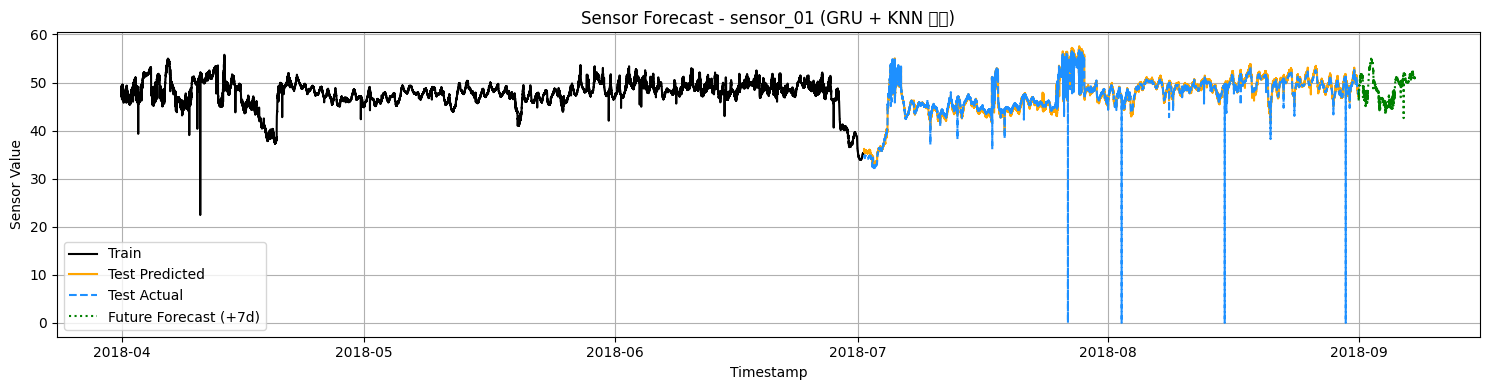

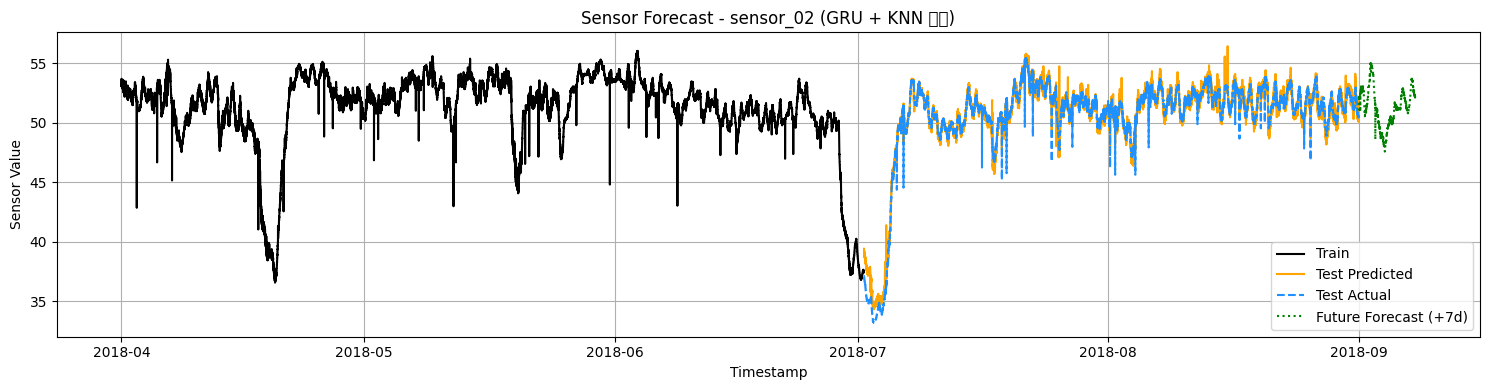

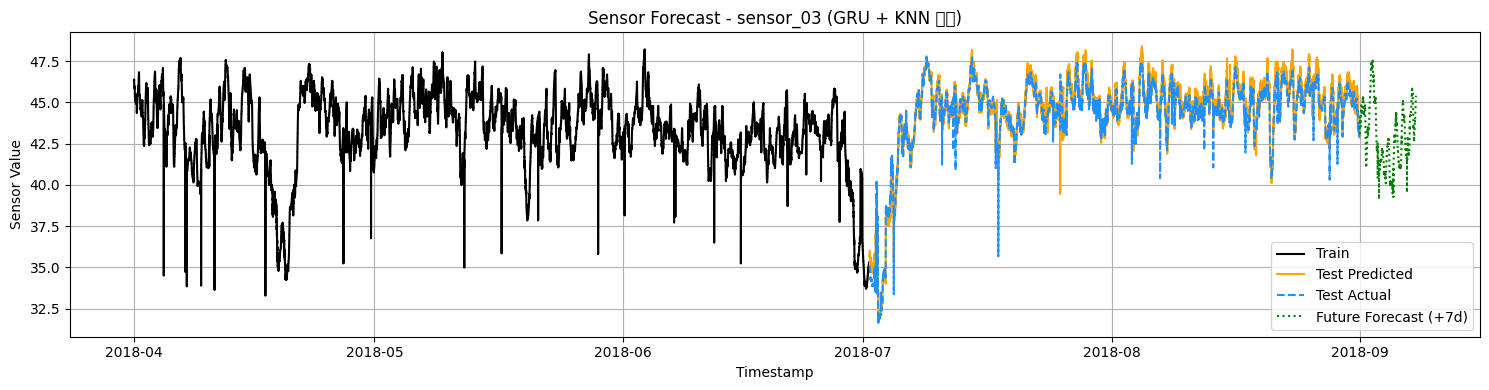

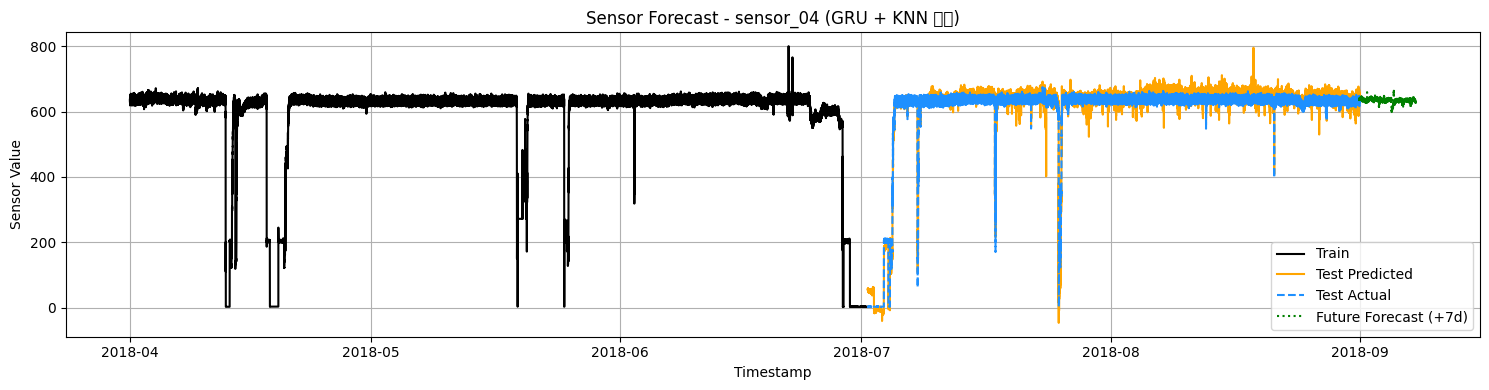

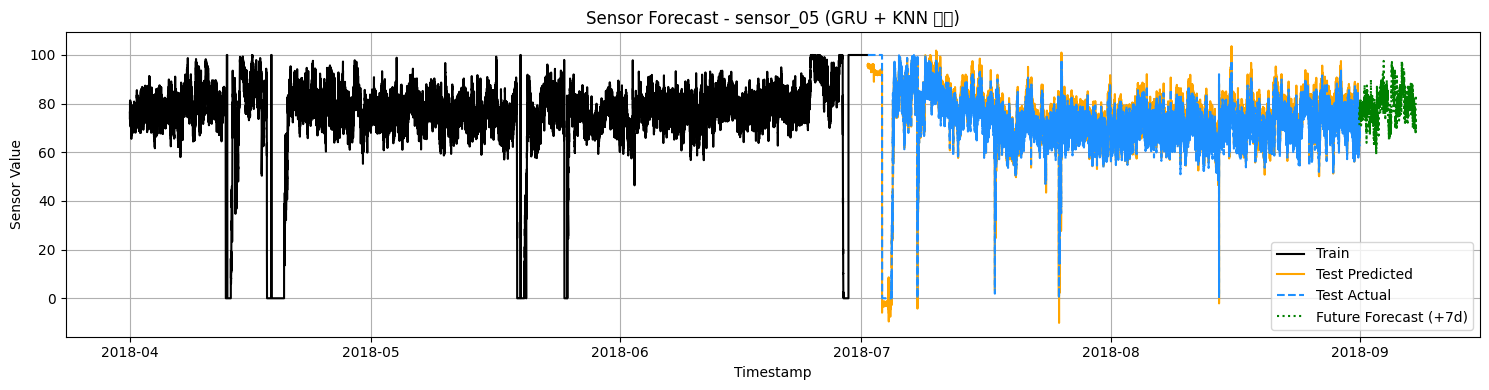

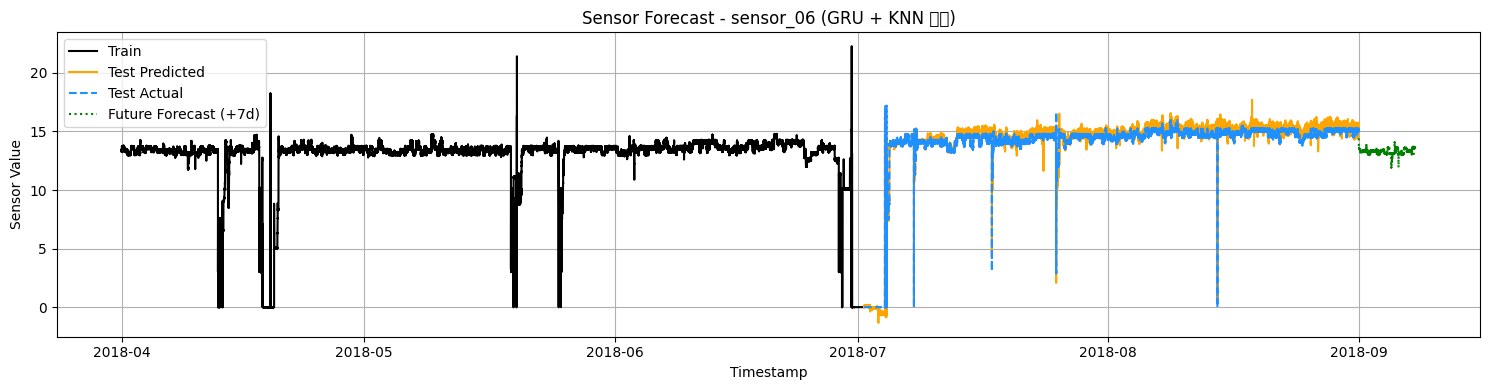

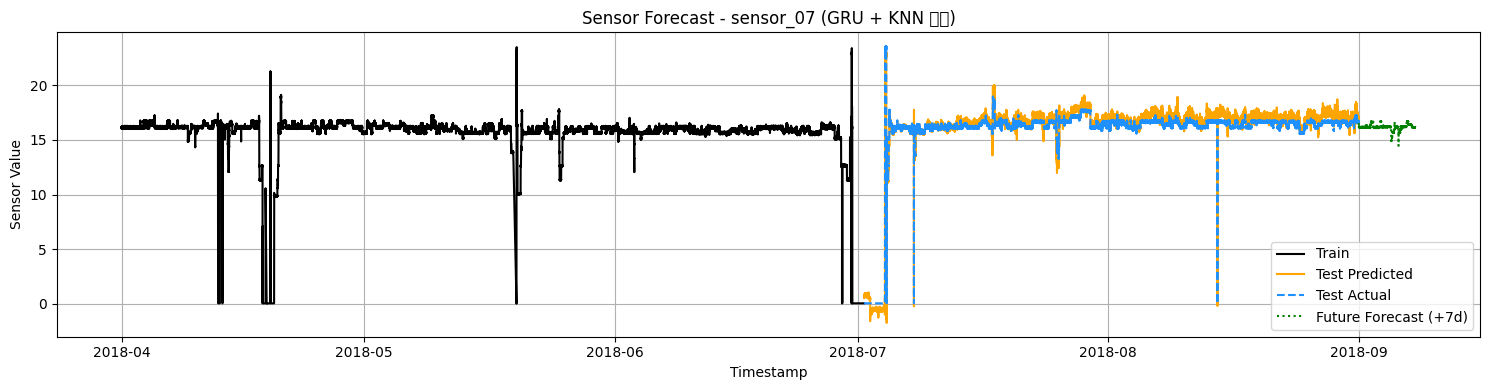

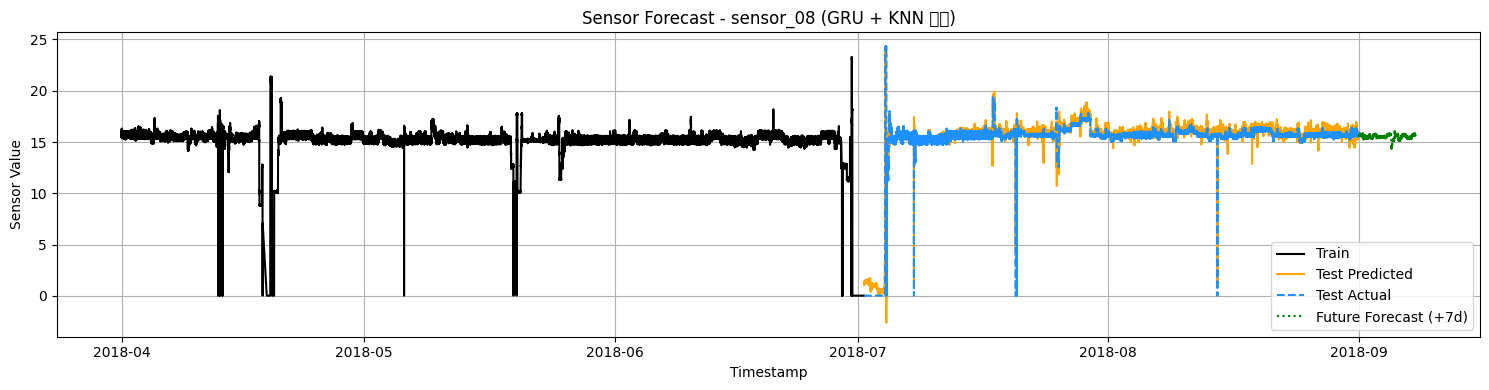

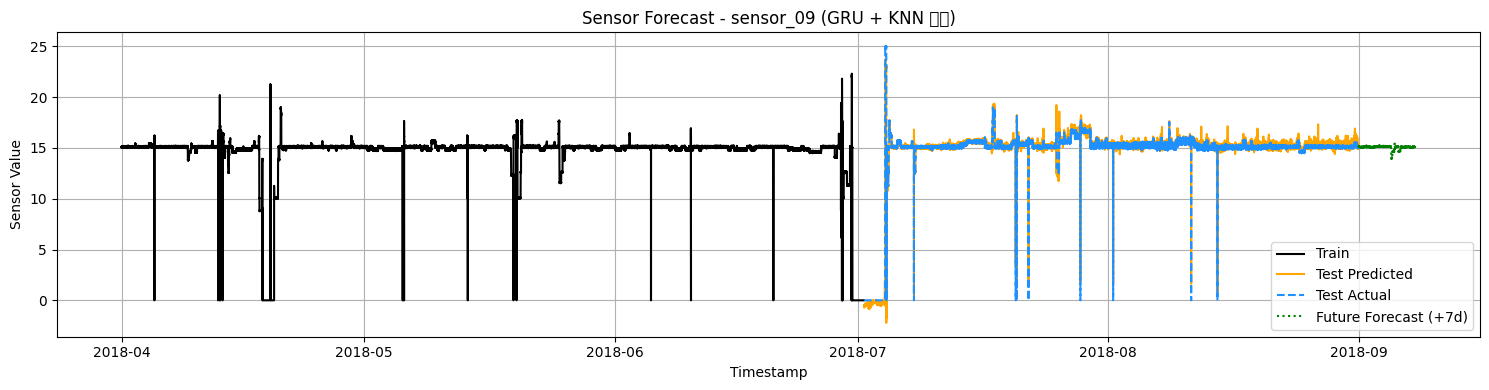

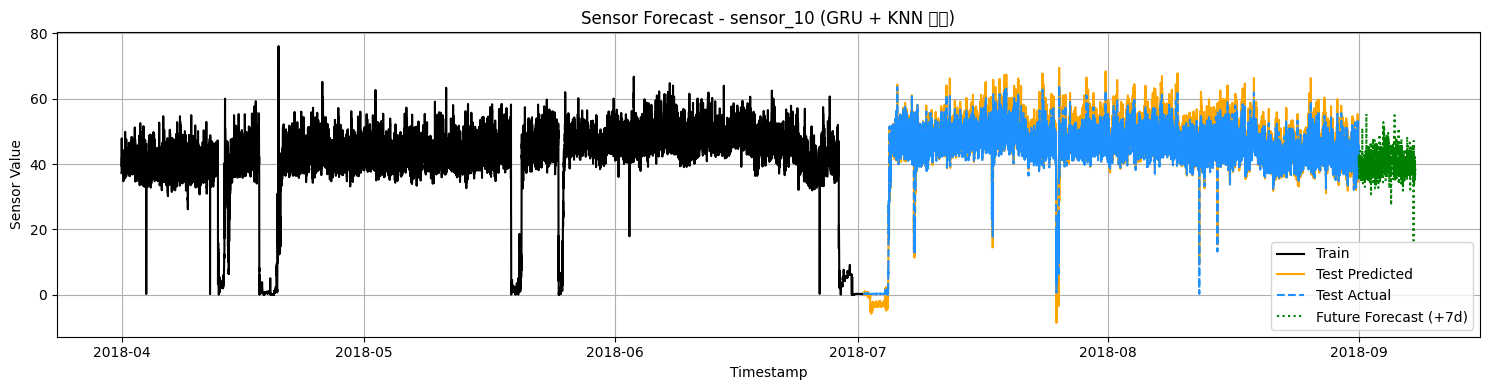

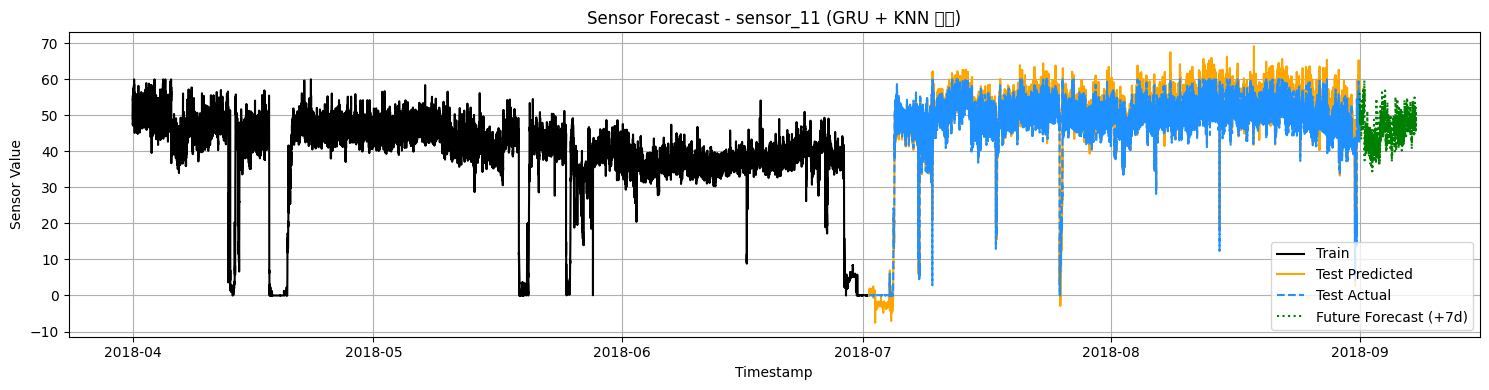

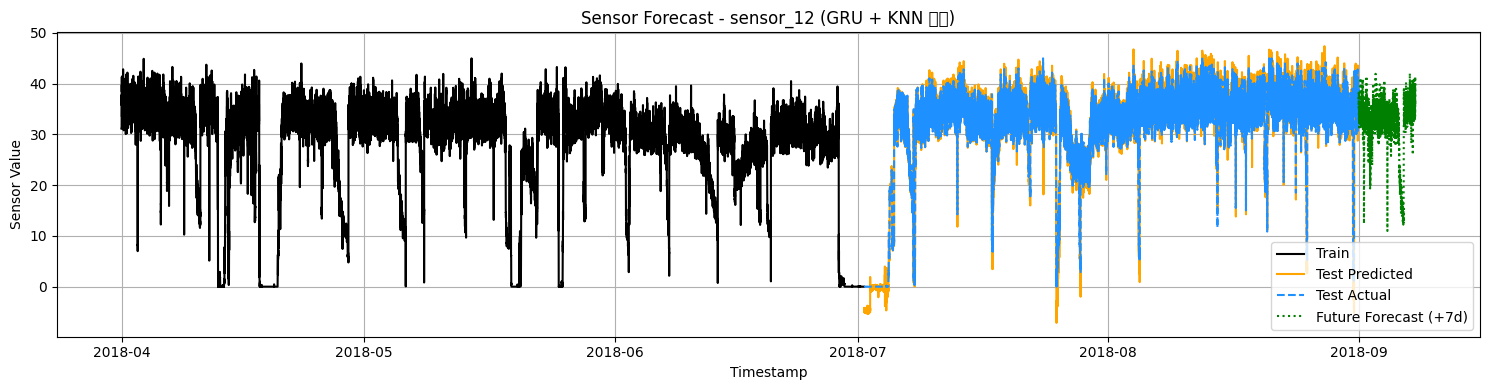

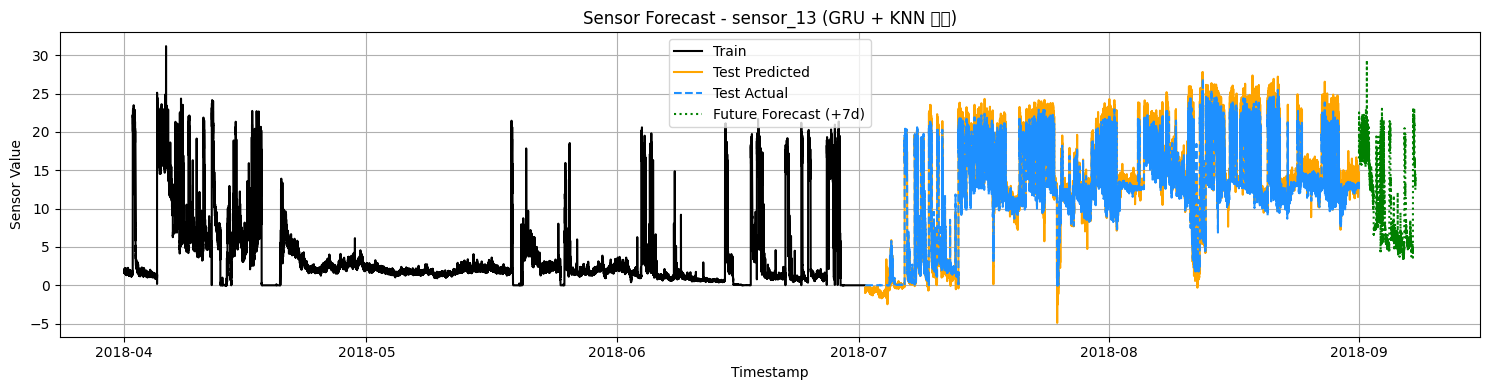

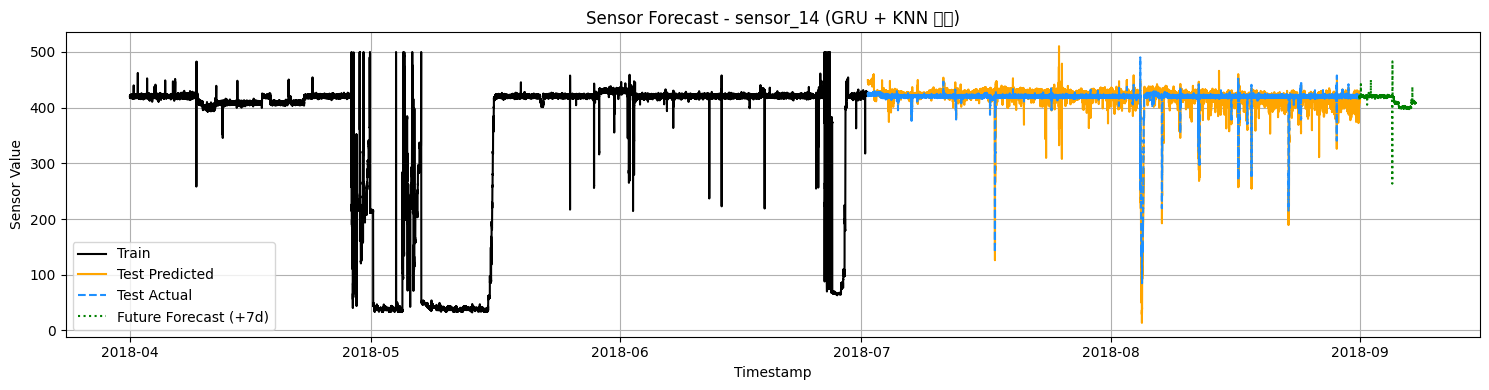

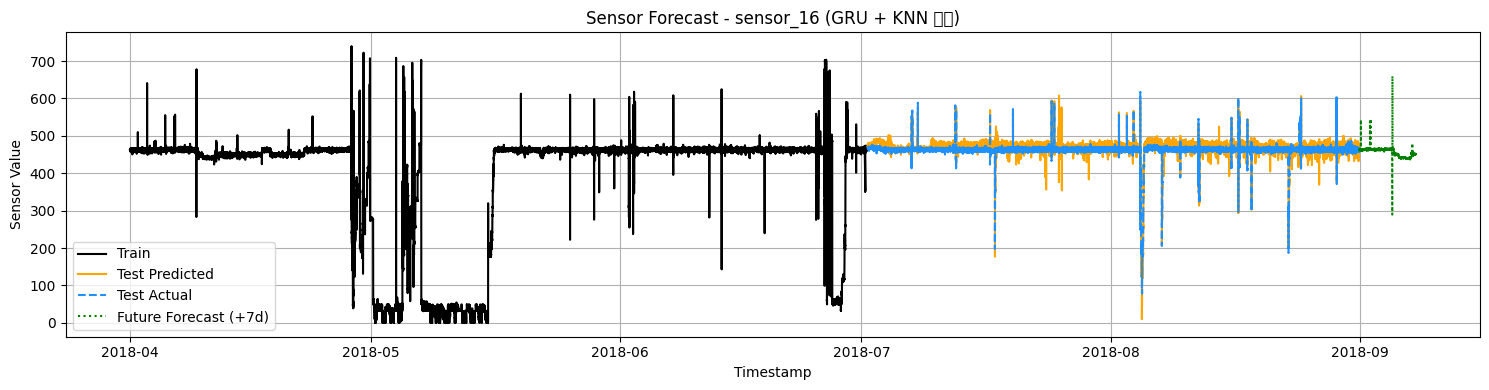

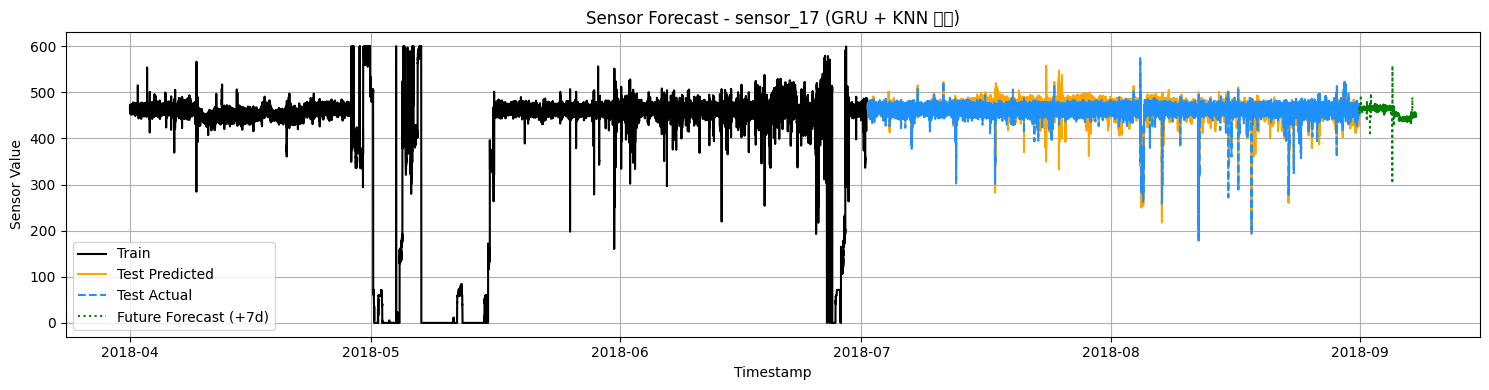

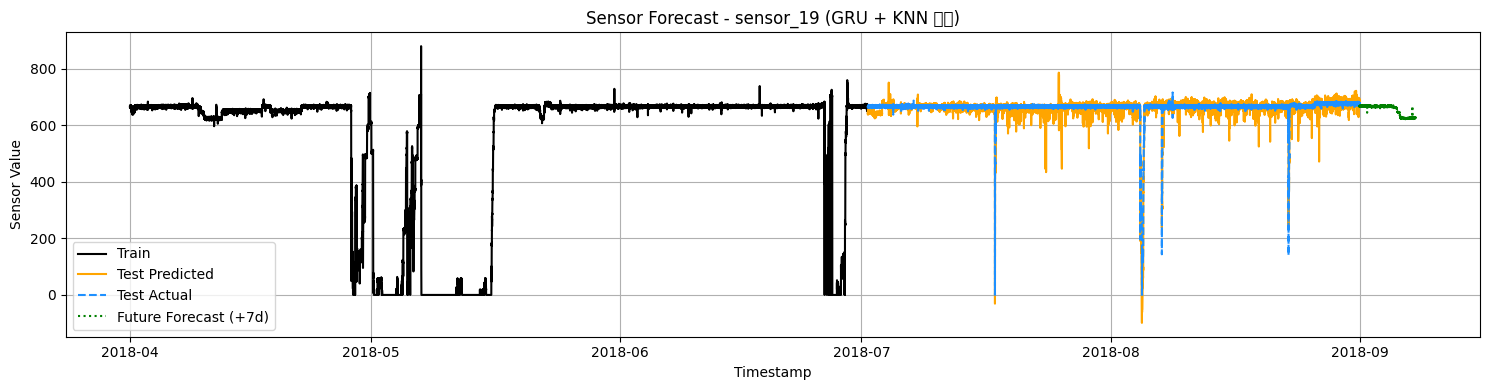

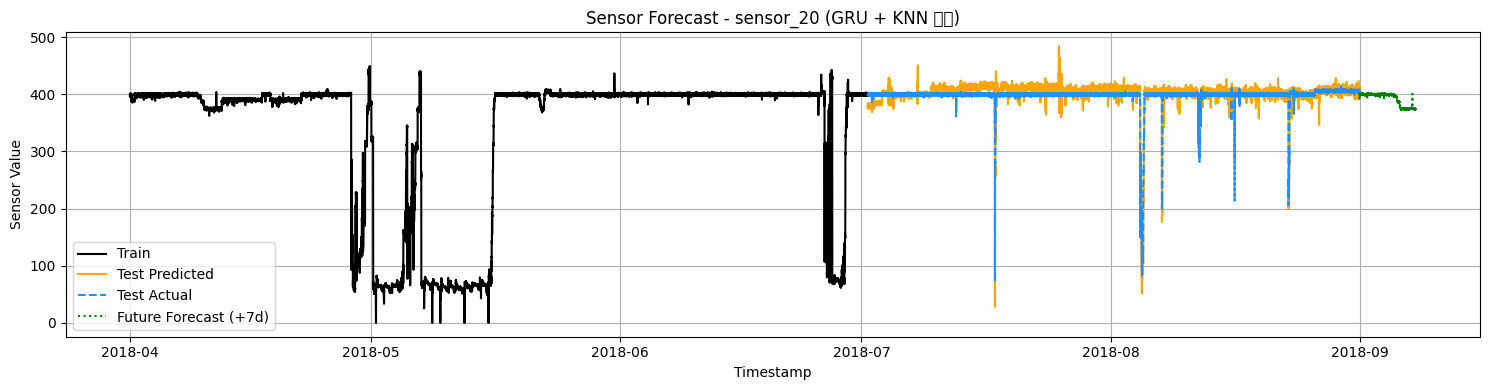

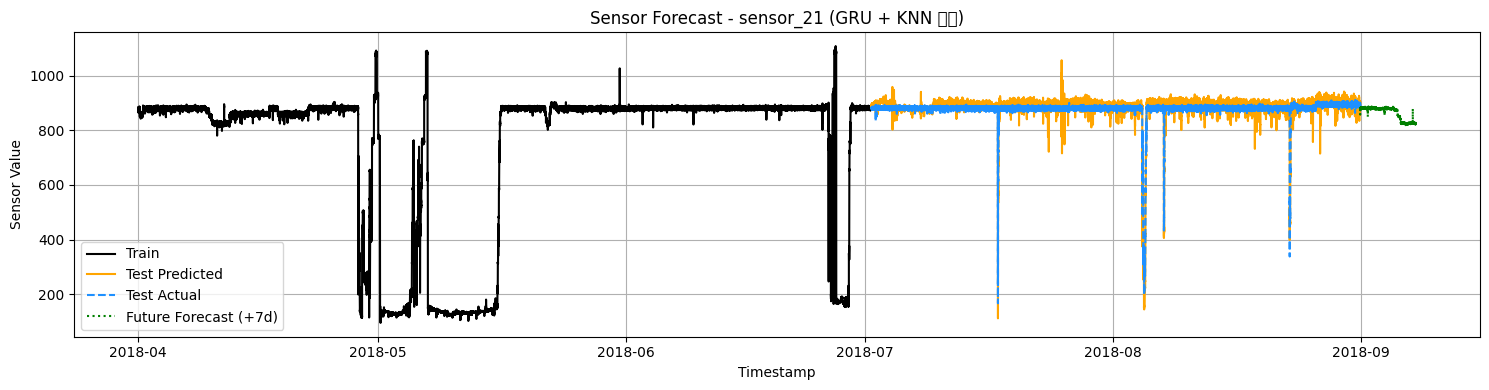

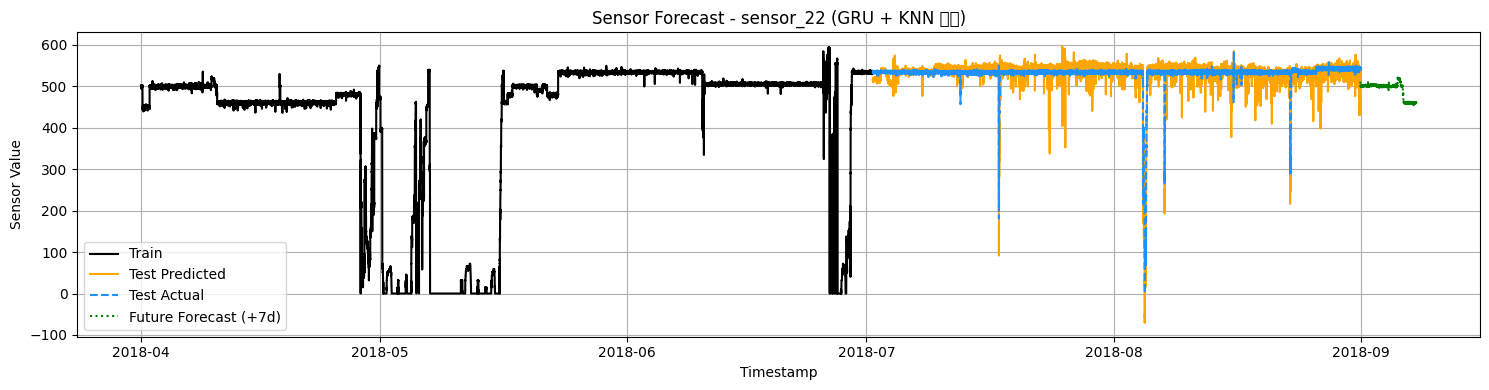

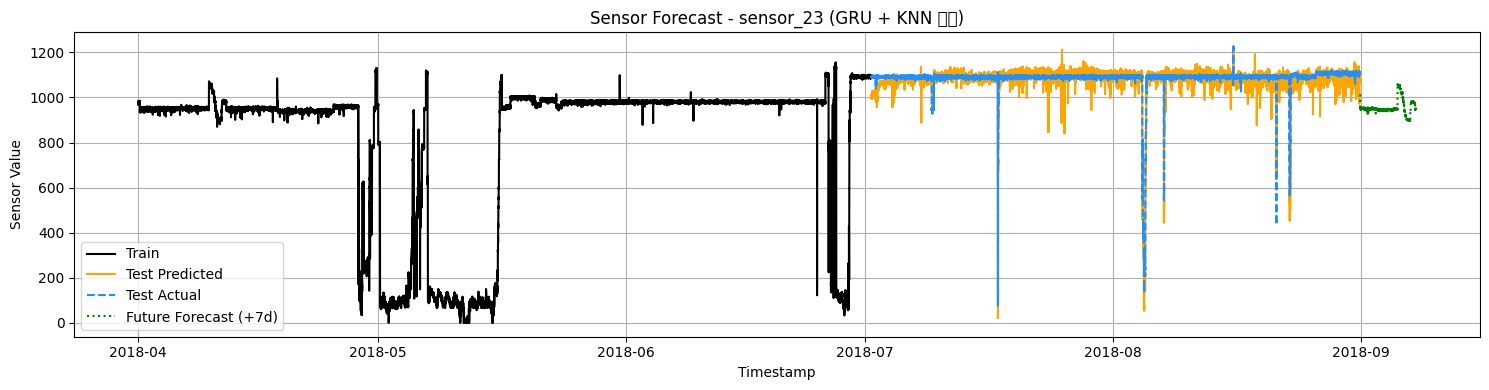

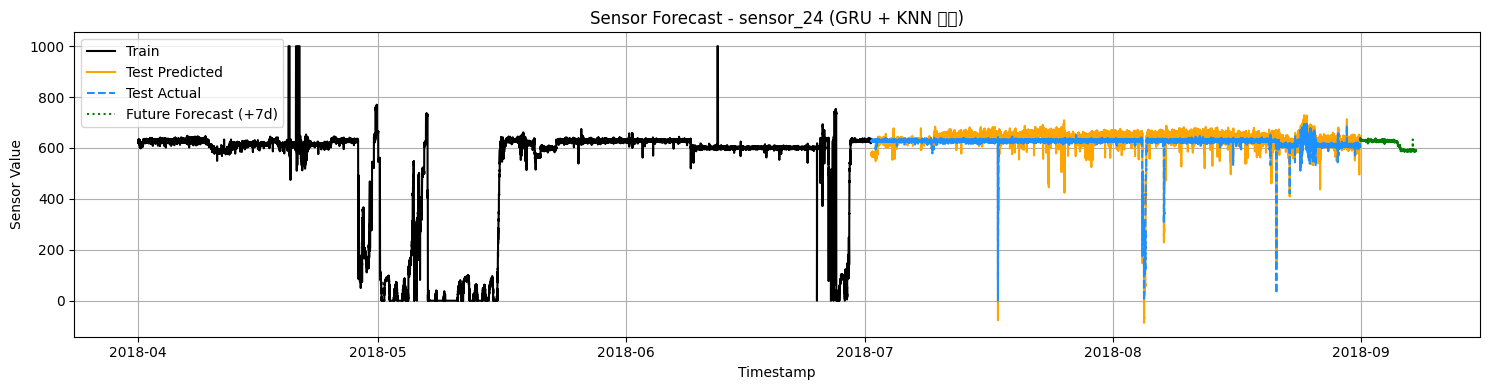

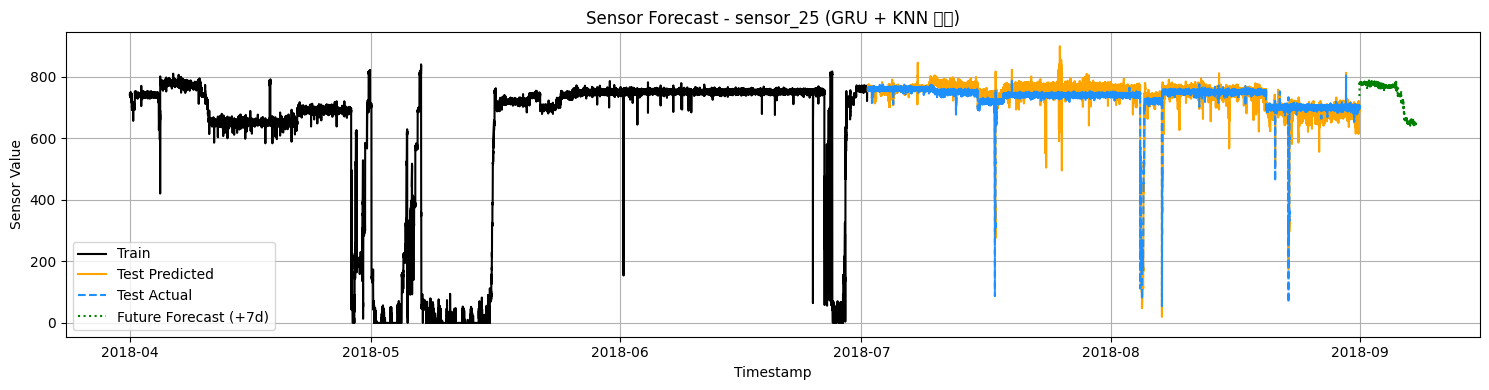

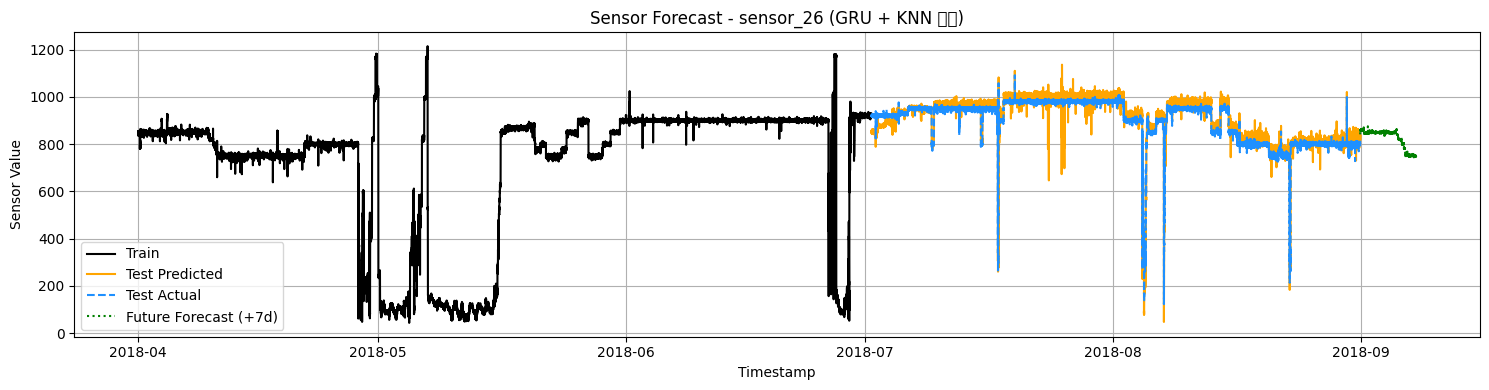

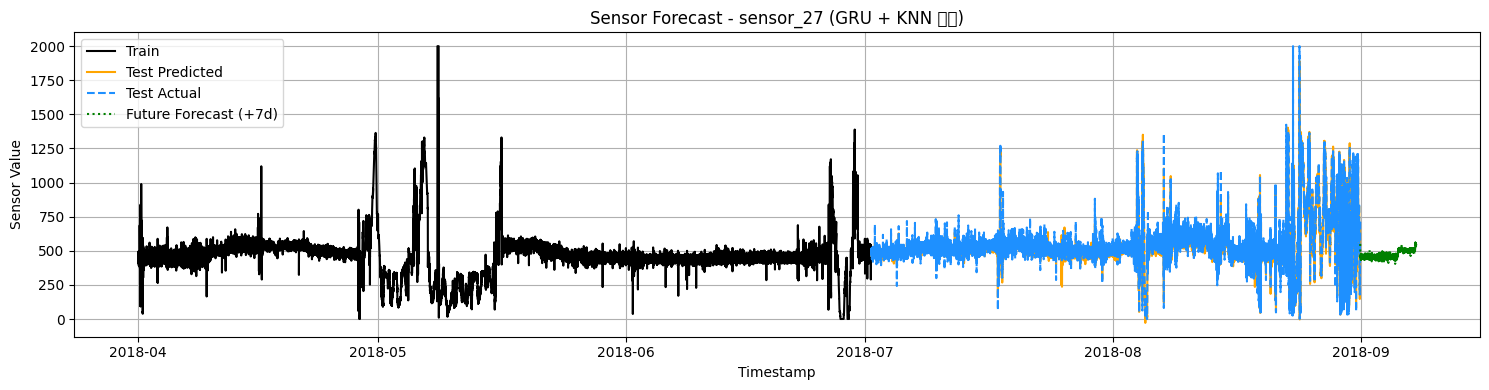

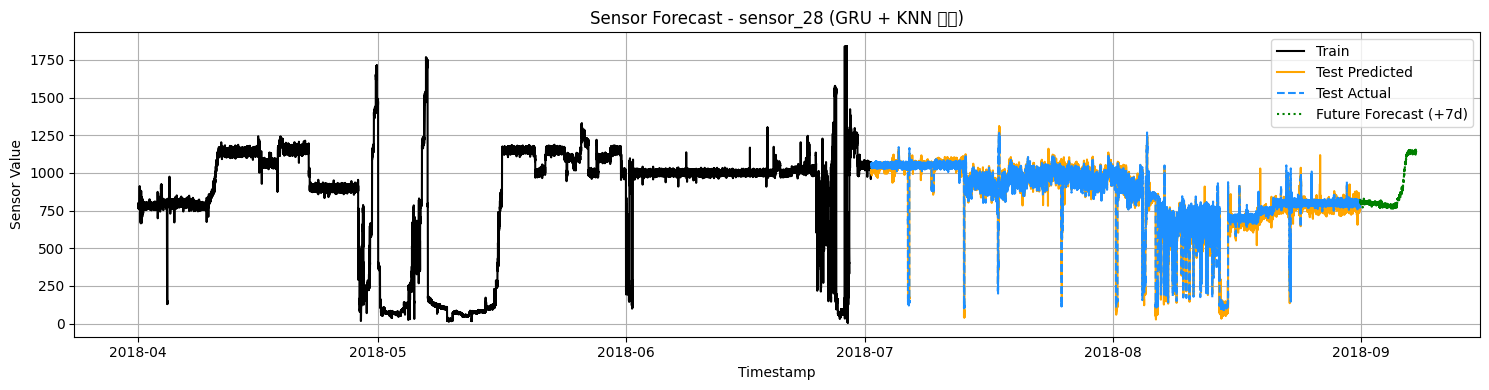

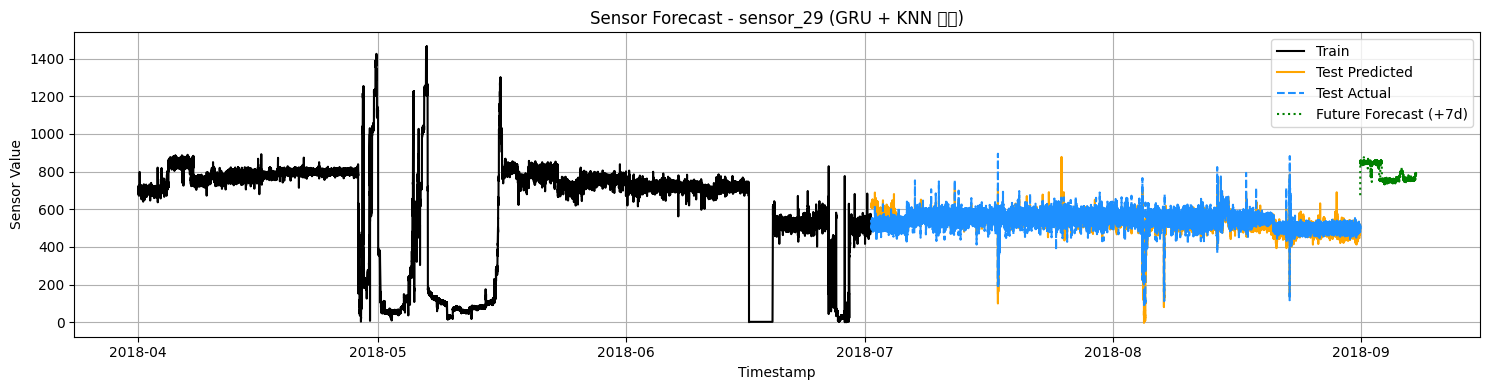

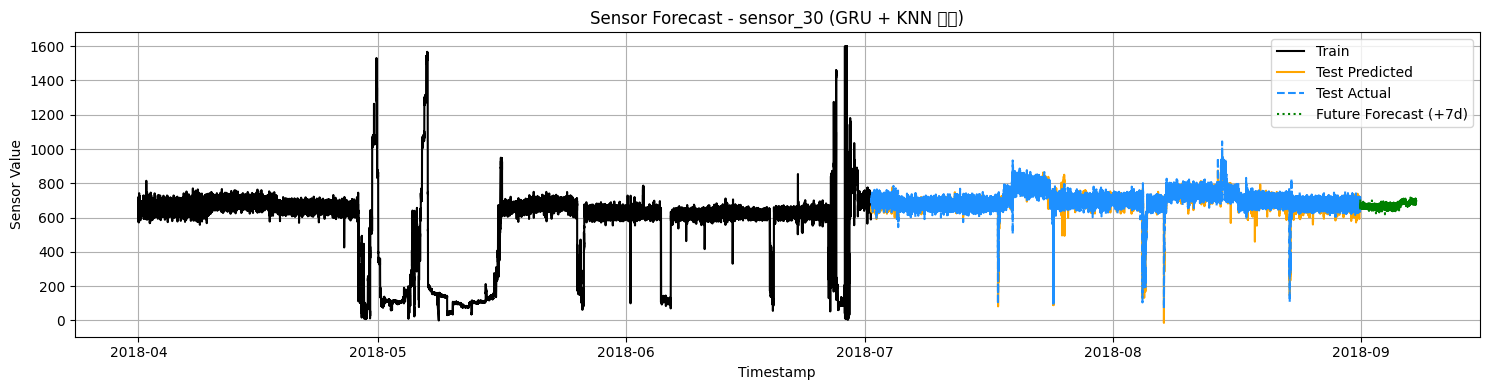

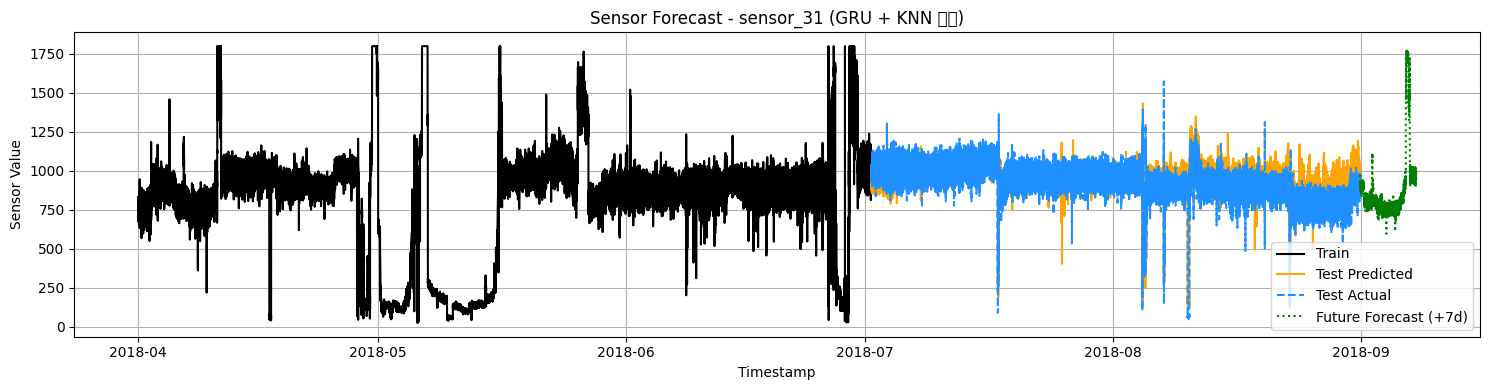

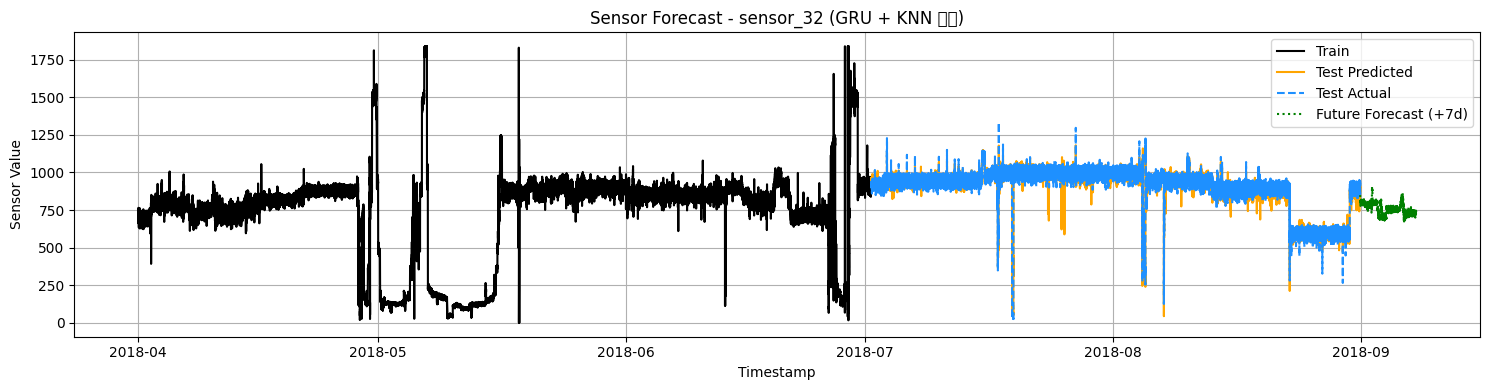

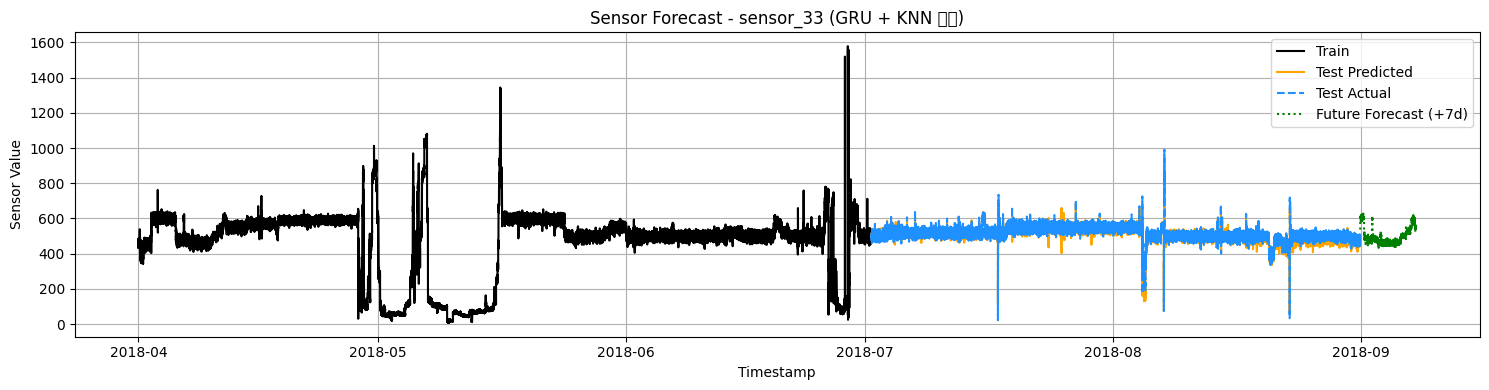

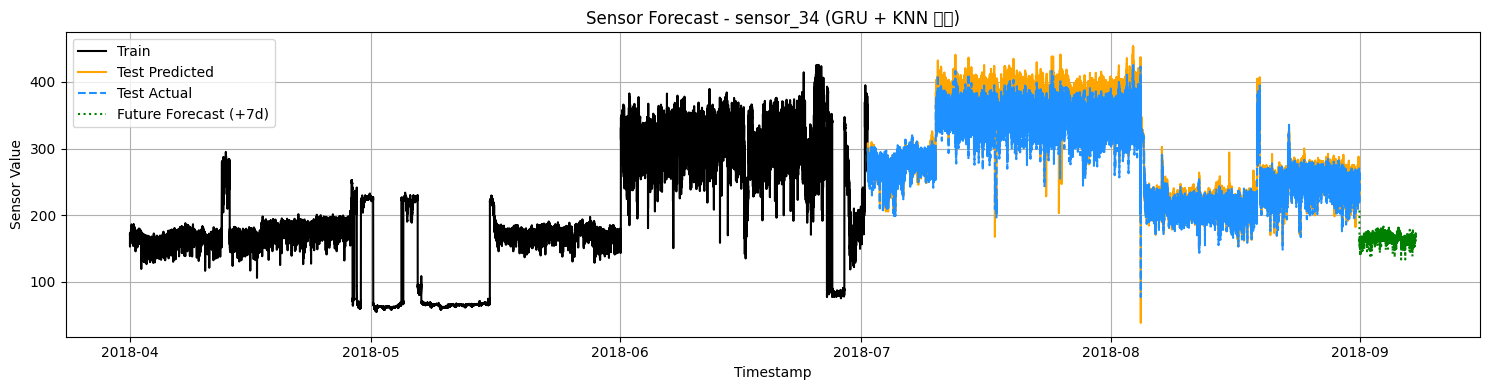

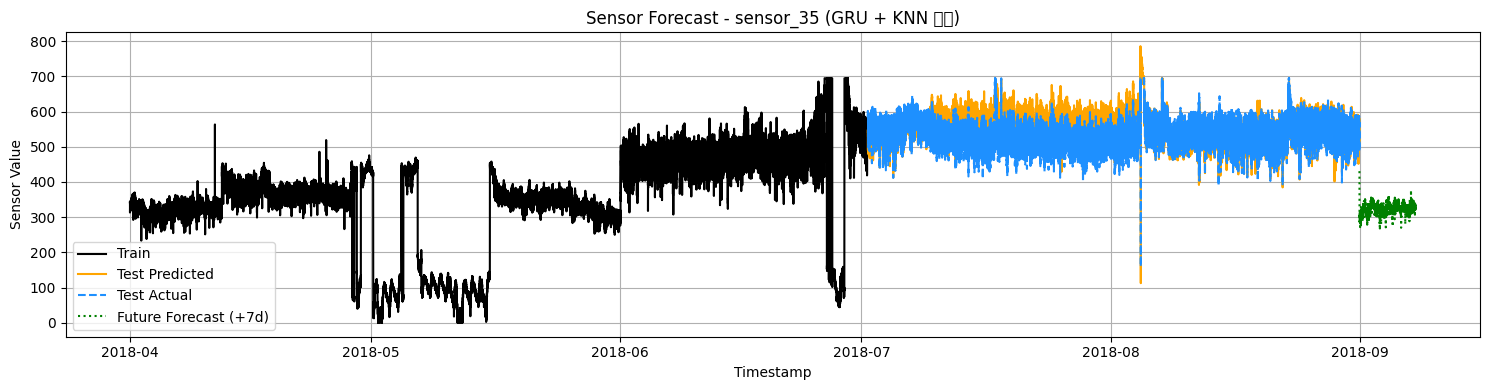

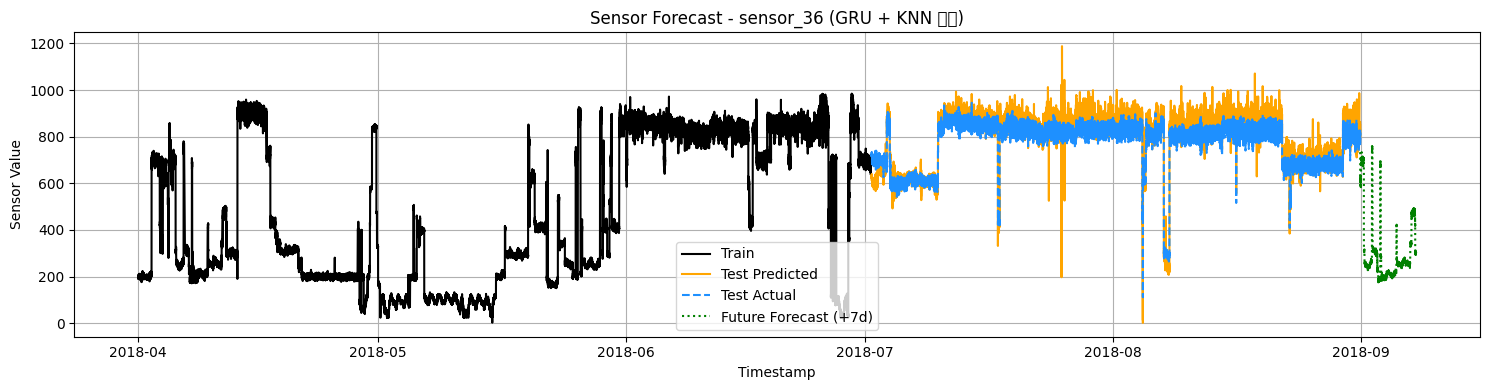

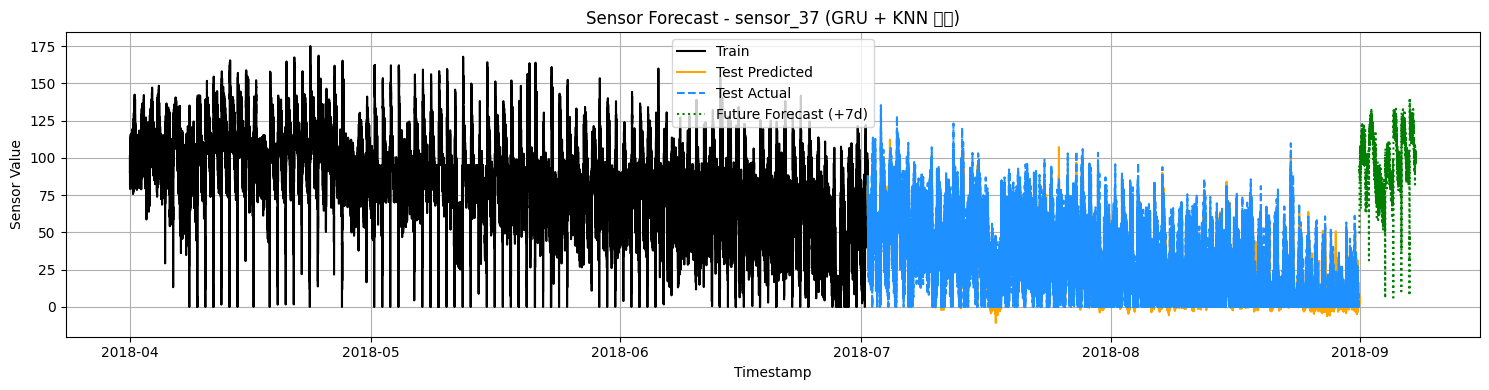

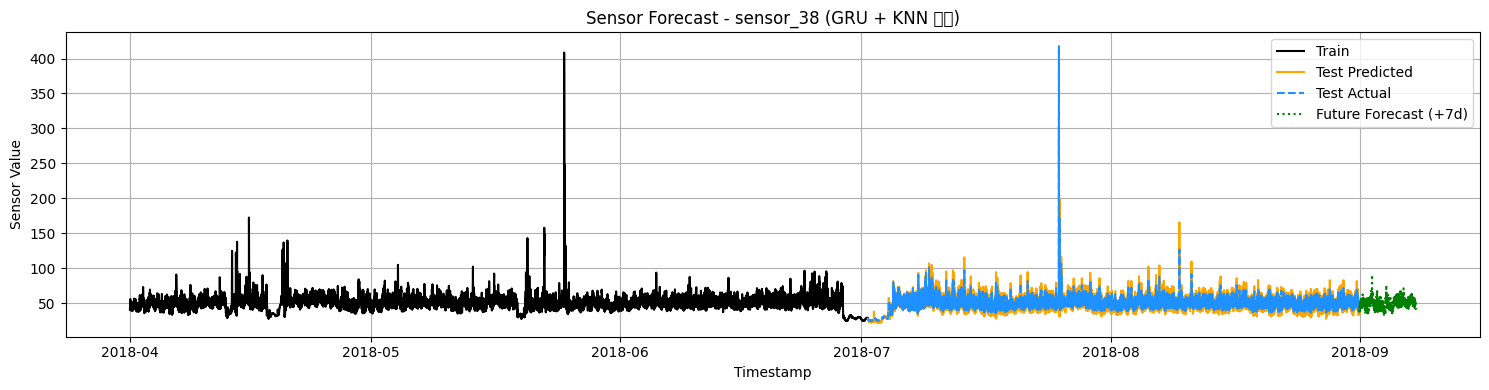

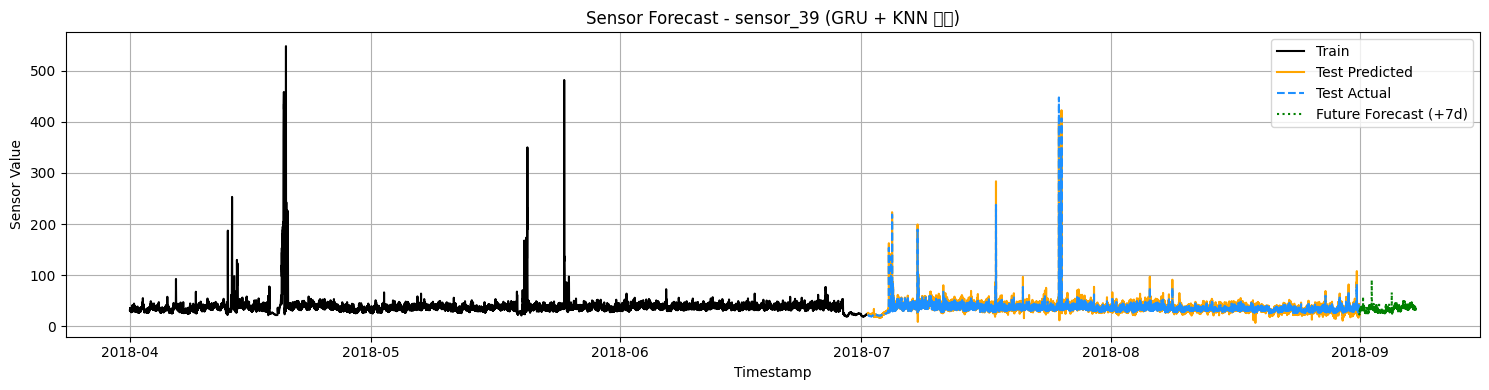

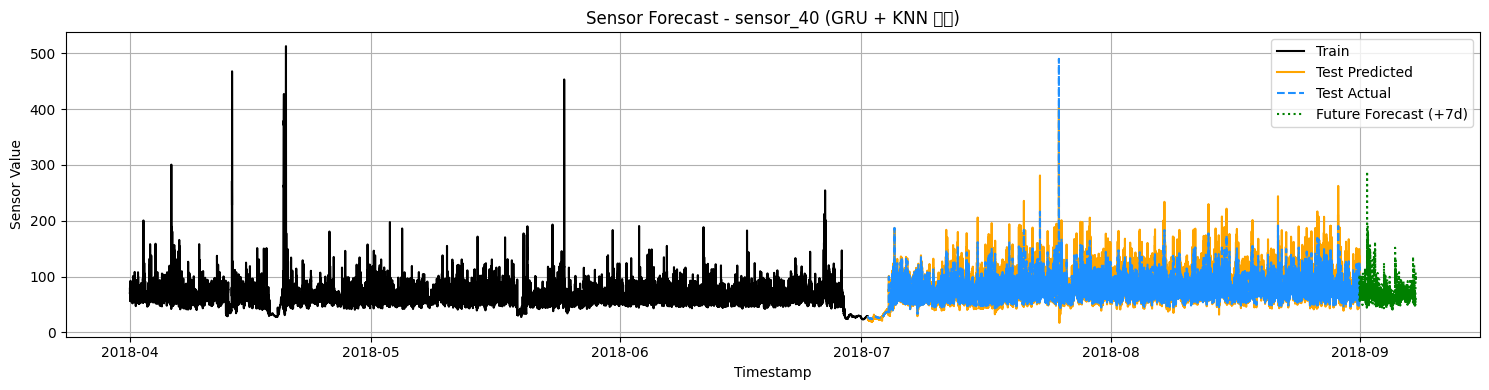

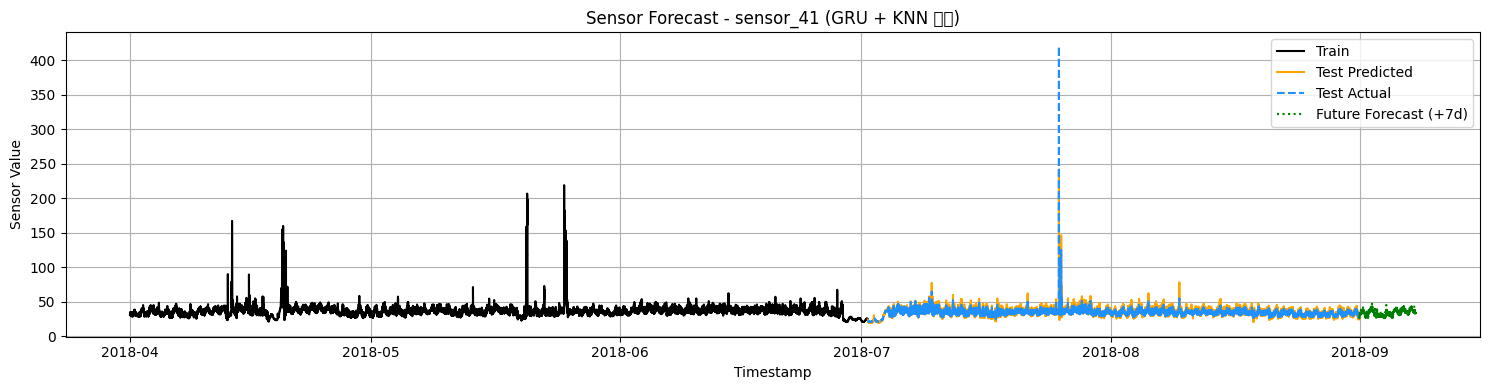

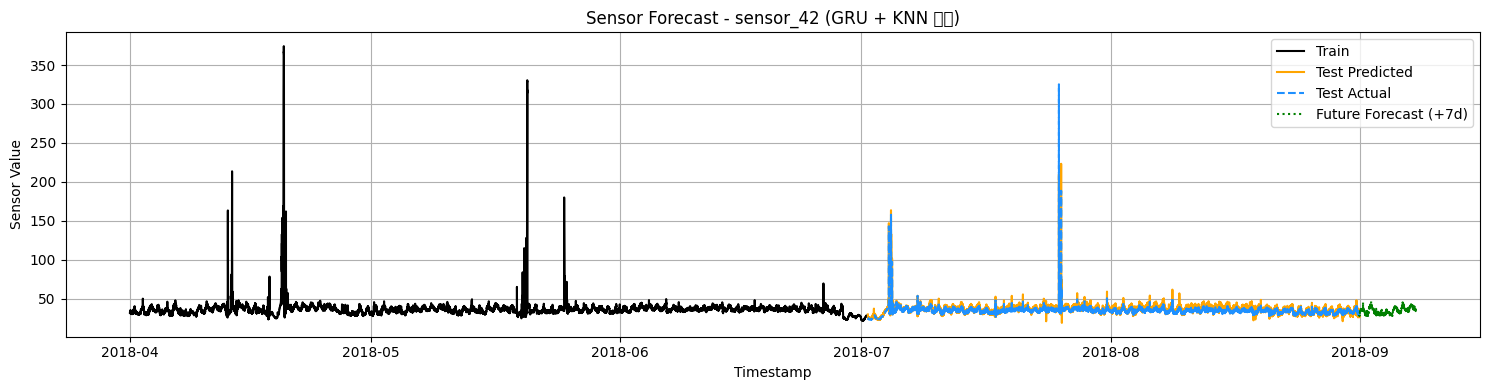

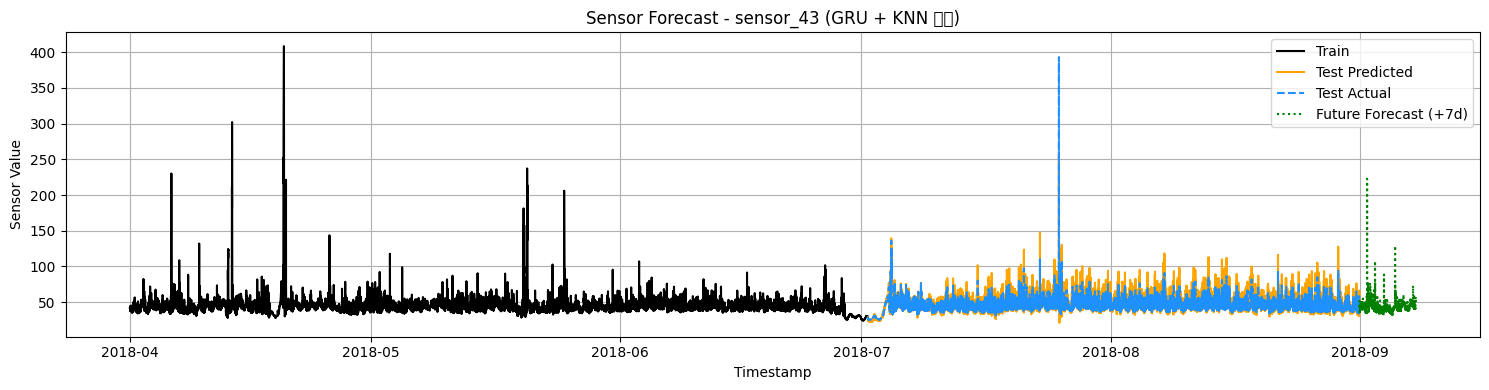

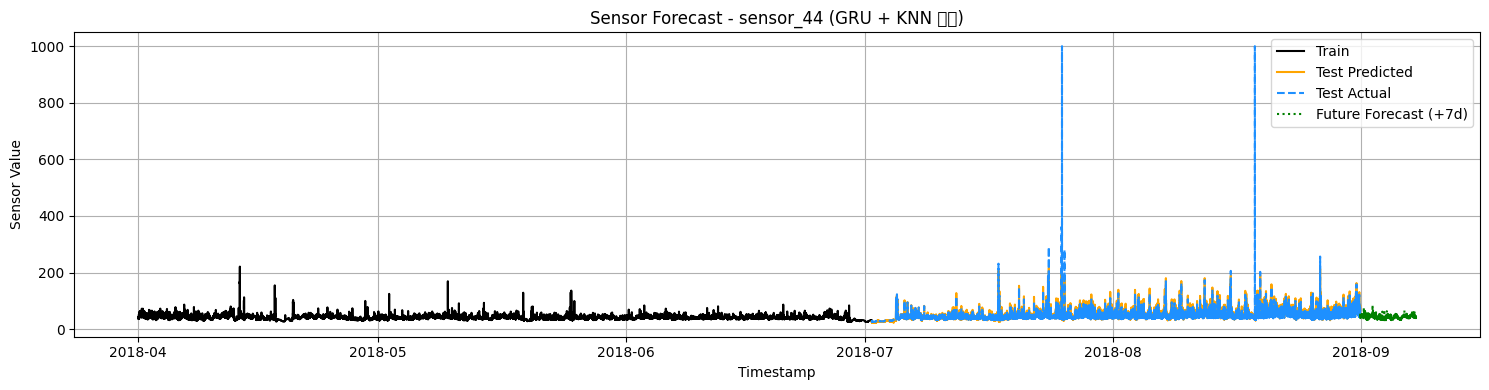

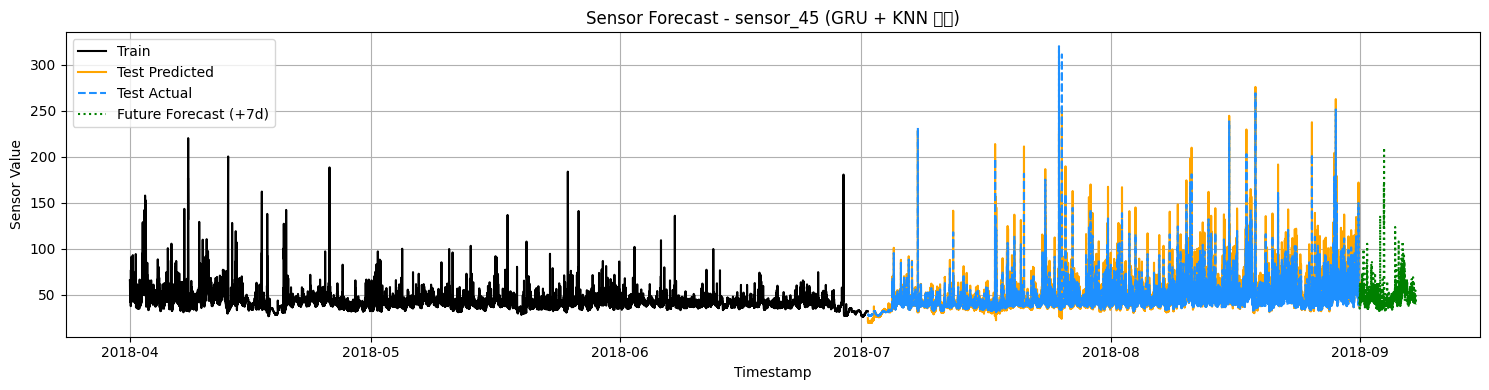

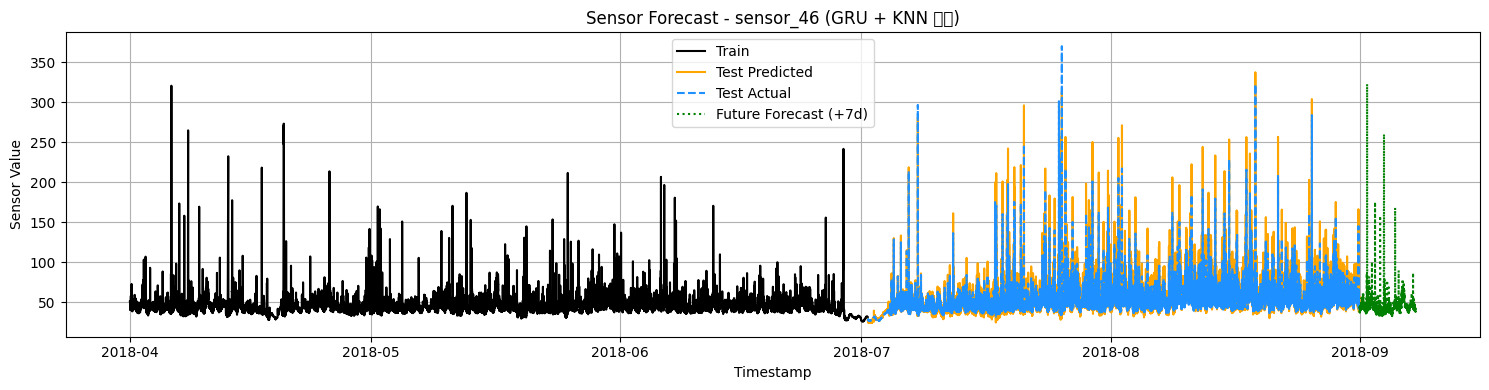

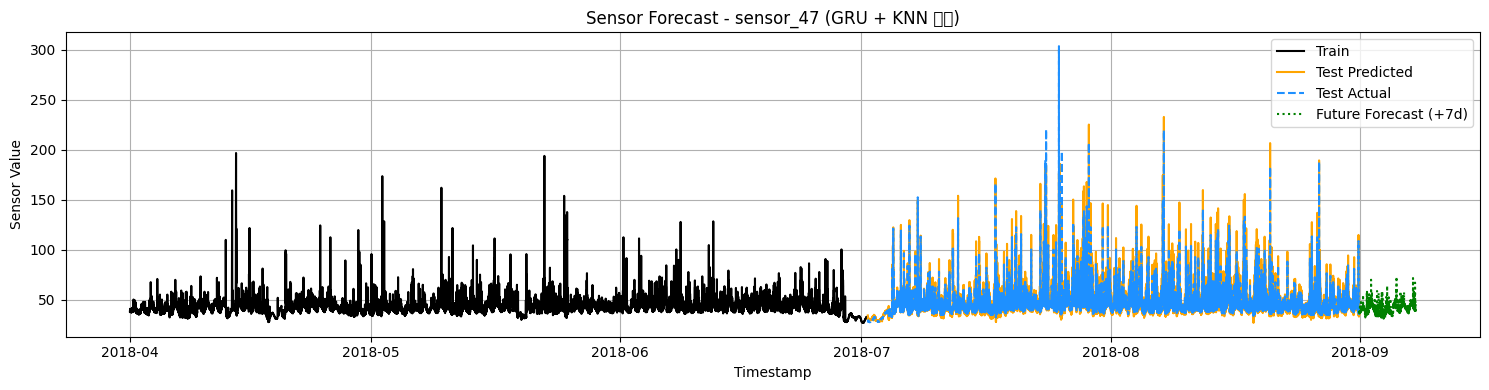

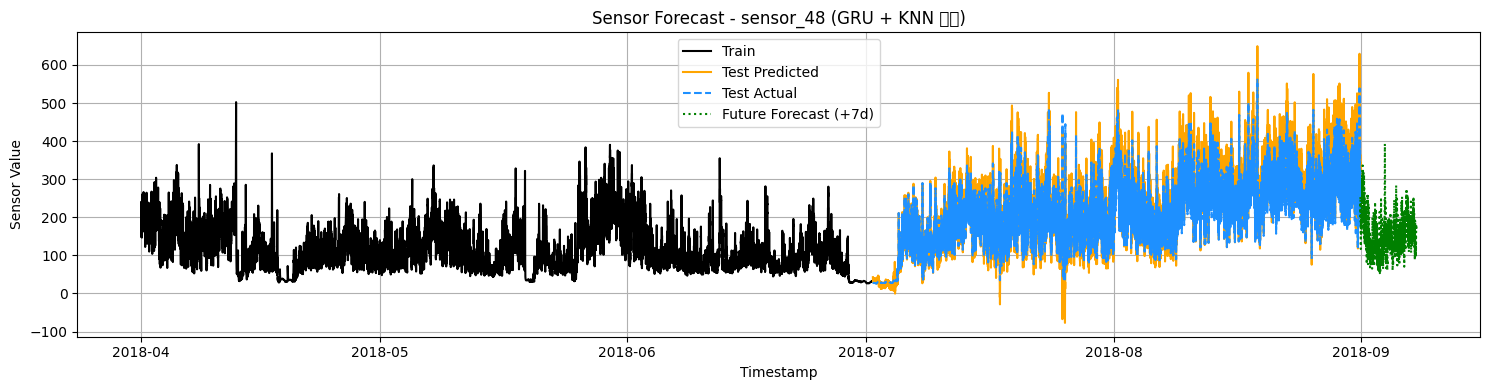

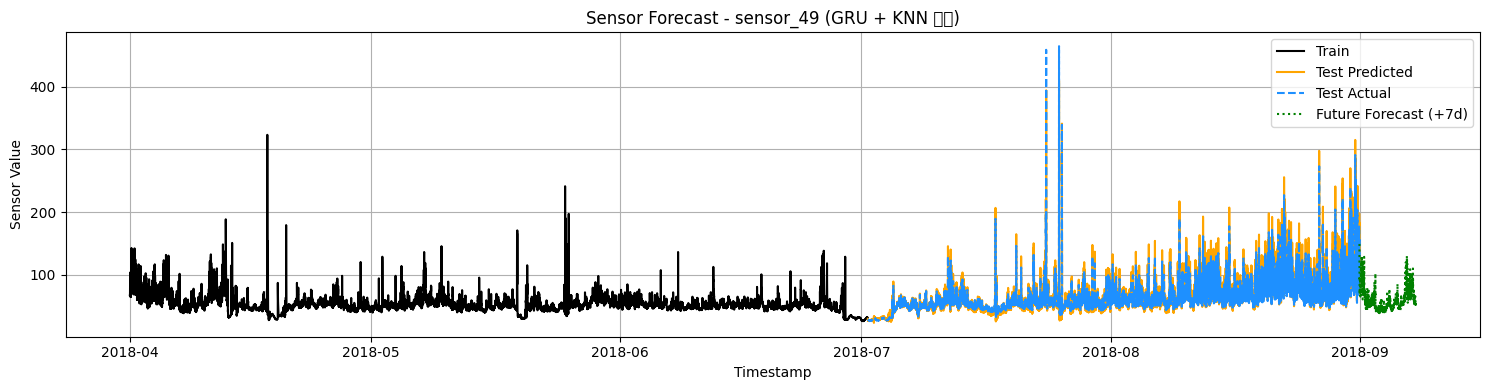

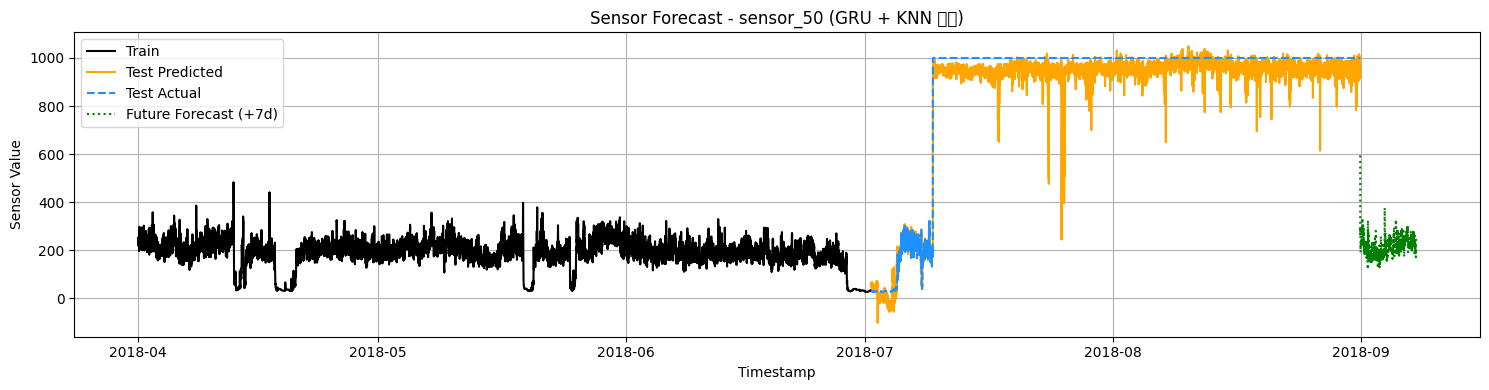

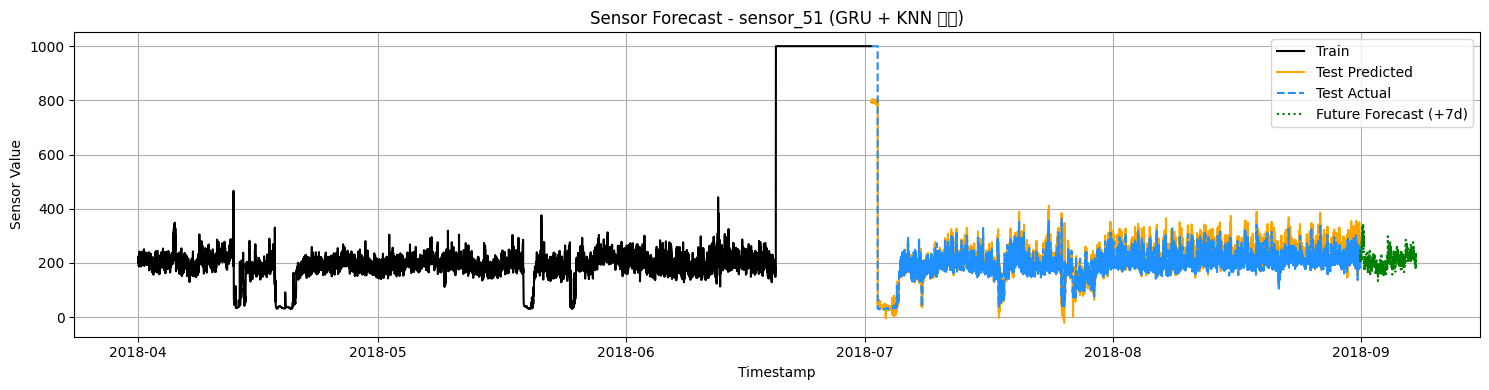

In [10]:
# 예측 트렌드 저장 (GRU+KNN 보정) - test구간 이후 시점 포함
window_bank, next_step_bank = [], []
train_arr = train_data[sensor_cols].values

for i in range(len(train_arr) - 60 - 1):
    window_bank.append(train_arr[i:i+60].flatten())
    next_step_bank.append(train_arr[i+60])

window_bank = np.array(window_bank)
next_step_bank = np.array(next_step_bank)

knn_model = NearestNeighbors(n_neighbors=3).fit(window_bank)

X_init = train_arr[-60:]
gru_first_pred = gru_trend_model.predict(X_init.reshape(1, 60, len(sensor_cols)))
gru_test_pred = gru_trend_model.predict(X_test)
gru_pred_full = np.vstack([gru_first_pred, gru_test_pred])

future_steps = 10080
future_preds = np.empty((future_steps, len(sensor_cols)))
last_input = X_test[-1:].copy()

for step in range(future_steps):
    pred = gru_trend_model.predict(last_input, verbose=0)[0]

    query = last_input.reshape(1, -1)
    indices = knn_model.kneighbors(query, return_distance=False)
    similar_nexts = next_step_bank[indices[0]]

    corrected = (pred + np.mean(similar_nexts, axis=0)) / 2
    future_preds[step] = corrected

    last_input = np.concatenate([last_input[:, 1:, :], corrected.reshape(1, 1, -1)], axis=1)

train_values_orig = scaler.inverse_transform(train_data[sensor_cols].values)
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(gru_pred_full)
future_pred_orig  = scaler.inverse_transform(future_preds)

time_gap = test_data.index[1] - test_data.index[0]
start_time = train_data.index[-1] + time_gap
pred_timestamps = [start_time + i * time_gap for i in range(len(y_pred_orig))]
future_timestamps = [pred_timestamps[-1] + (i+1)*time_gap for i in range(future_steps)]

for i, sensor in enumerate(sensor_cols):
    plt.figure(figsize=(15, 4))
    plt.plot(train_data.index, train_values_orig[:, i], label="Train", color="black")
    plt.plot(pred_timestamps, y_pred_orig[:, i], label="Test Predicted", color="orange")
    plt.plot(pred_timestamps[1:], y_test_orig[:, i], label="Test Actual", color="dodgerblue", linestyle='--')
    plt.plot(future_timestamps, future_pred_orig[:, i], label="Future Forecast (+7d)", color="green", linestyle=':')
    plt.title(f"Sensor Forecast - {sensor} (GRU + KNN 보정)")
    plt.xlabel("Timestamp")
    plt.ylabel("Sensor Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

C:\Users\LEETJ\AppData\Local\Temp\ipykernel_13324\3532633002.py:56: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LEETJ\AppData\Local\Temp\ipykernel_13324\3532633002.py:56: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LEETJ\AppData\Local\Temp\ipykernel_13324\3532633002.py:56: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LEETJ\AppData\Local\Temp\ipykernel_13324\3532633002.py:56: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LEETJ\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\LEETJ\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabt

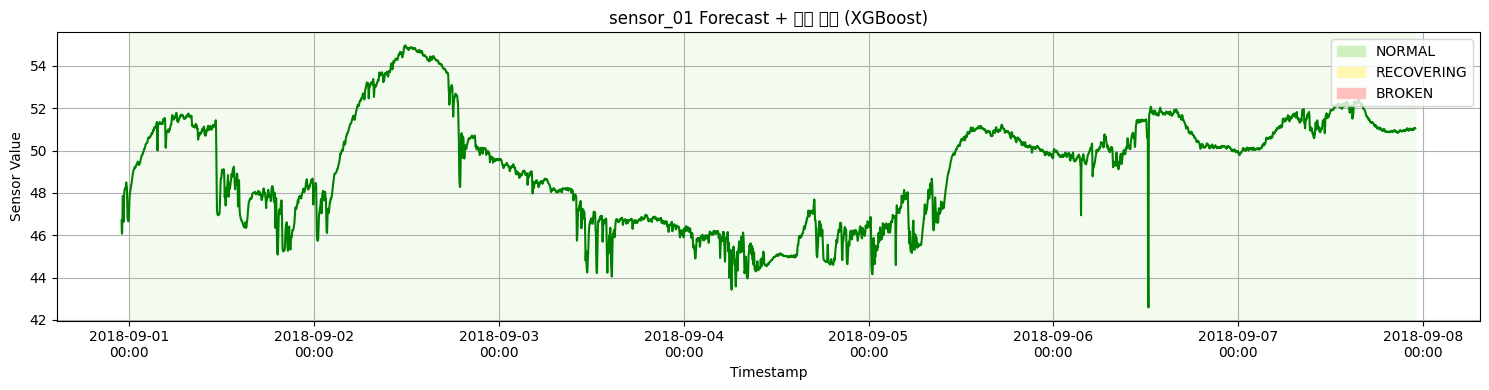

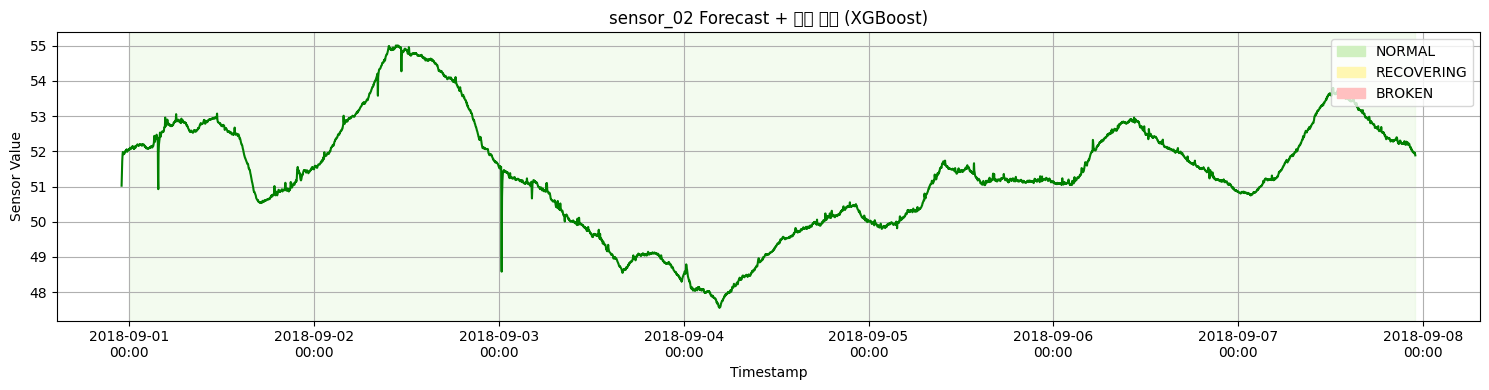

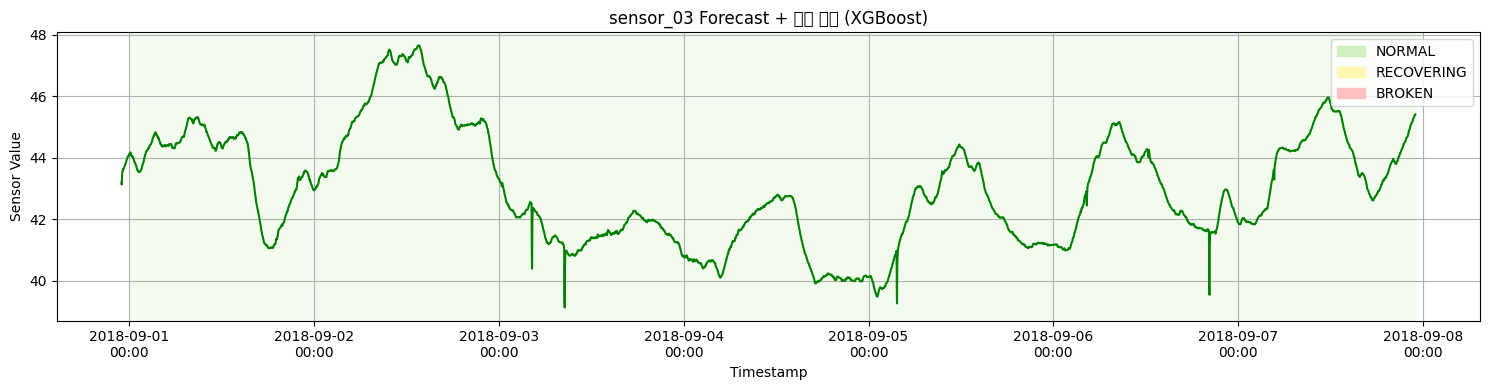

In [11]:
# 비고: 예측된 7일 기반 상태 평가 수행
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

xgb_model = xgb.XGBClassifier()
xgb_model.load_model("data/xgb_model.json")

window_size = 60
future_X = []

for i in range(len(future_pred_orig) - window_size):
    future_X.append(future_pred_orig[i:i+window_size])

future_X = np.array(future_X)
future_X_flat = future_X.reshape(future_X.shape[0], -1)

future_status_pred = xgb_model.predict(future_X_flat)
status_map = {0: 'NORMAL', 1: 'RECOVERING', 2: 'BROKEN'}
status_colors = {0: '#d0f0c0', 1: '#fff7b2', 2: '#ffc0c0'}

future_status_timestamps = future_timestamps[window_size:]

for i, sensor in enumerate(sensor_cols[:3]):
    plt.figure(figsize=(15, 4))
    plt.plot(future_timestamps, future_pred_orig[:, i], label=f"{sensor} (Forecast)", color="green")

    prev_status = future_status_pred[0]
    start_idx = 0
    for idx in range(1, len(future_status_pred)):
        if future_status_pred[idx] != prev_status or idx == len(future_status_pred) - 1:
            end_idx = idx
            plt.axvspan(
                future_status_timestamps[start_idx],
                future_status_timestamps[end_idx],
                color=status_colors.get(prev_status, "#eeeeee"),
                alpha=0.25
            )
            prev_status = future_status_pred[idx]
            start_idx = idx

    plt.title(f"{sensor} Forecast + 상태 예측 (XGBoost)")
    plt.xlabel("Timestamp")
    plt.ylabel("Sensor Value")
    plt.grid(True)
    plt.legend()

    legend_patches = [
        mpatches.Patch(color=status_colors[0], label='NORMAL'),
        mpatches.Patch(color=status_colors[1], label='RECOVERING'),
        mpatches.Patch(color=status_colors[2], label='BROKEN'),
    ]
    plt.legend(handles=legend_patches, loc='upper right')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    plt.tight_layout()
    plt.show()
